In [207]:
import json
import re
from collections import Counter
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
import networkx as nx
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np
import baltic as bt

In [2]:
def get_dates(virus, num_tips=10000):
    """
    Return dictionary mapping node to date
    """
    tree_path= f'../nextstrain_builds/egg-enriched/{num_tips}tips/auspice/{virus}_30y_egg_ha.json'
    
    #read in the tree
    with open(tree_path, 'r') as f:
        tree_json = json.load(f)
        
    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    node_dates = {}
    
    for node in tree.find_clades():
        node_dates[node.name] = node.node_attrs['num_date']['value']
        
    return node_dates

In [3]:
def get_parent_nodes(virus, num_tips):
    """
    Get all internal nodes where no HA1 muts happen on their children branches (except in eggs)
    """
    
    tree_path= f'../nextstrain_builds/egg-enriched/{num_tips}tips/auspice/{virus}_30y_egg_ha.json'
    
    #read in the tree
    with open(tree_path, 'r') as f:
        tree_json = json.load(f)
        
    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    

    # start by finding all branches will only egg descendents
    # may be terminal or non-terminal
    egg_only_descendents = []
    
    for node in tree.find_clades():

        descending_tips = node.get_terminals()
        # don't think we'll ever see an egg only cluster of 20 or more
        if len(descending_tips) < 25:
            # find the passage type of all the descending tips
            passage_type_descendants = set([x.node_attrs['passage_category']['value'] for x in descending_tips])
            # add egg-only clusters to list
            if passage_type_descendants == {'egg'}:
                egg_only_descendents.append(node.name)
                
    # now trace egg-only cluster path back as far as possible without encountering an HA1 mut
    parent_nodes_wo_muts = {}
    for d in egg_only_descendents:
        # walking backwards, check for HA1 muts
        found_ha1_mut = False
        parents_wo_ha1_muts = []
        for p in tree.get_path(d)[::-1]:
            # don't look on d's branch (branch leading to egg cluster)
            if p.name!=d:
                # if we haven't seen an ha1 mut yet
                if found_ha1_mut == False:
                    if 'HA1' in p.branch_attrs['mutations']:
                        found_ha1_mut = True
                    else:
                        parents_wo_ha1_muts.append(p.name)
        parent_nodes_wo_muts[d] = parents_wo_ha1_muts
                        

    # now need to find internal nodes in the lists that are shared by multiple egg clusters
    possiblities = list(set([x for xs in parent_nodes_wo_muts.values() for x in xs]))

    egg_clusters_by_possibility = {p:[] for p in possiblities}
    for clus, pars in parent_nodes_wo_muts.items():
        for p in pars:
            egg_clusters_by_possibility[p].append(clus)
            
    # some of these will be overlapping, so get rid of those (take the largest possible clade)
    
    # convert the dictionary into a list of tuples to compare
    clades = list(egg_clusters_by_possibility.items())
    cleaned_clades = {}

    for parent_node, egg_children in clades:
        is_subset = False
        for other_parent, other_children in clades:
            if parent_node != other_parent and set(egg_children).issubset(set(other_children)):
                is_subset = True
                break
        if not is_subset:
            cleaned_clades[parent_node] = egg_children
            
    return cleaned_clades

In [4]:
adaptive_muts_by_virus = {'h3n2':{138:['S'], 156: ['Q','R'], 160: ['K', 'I'], 186: ['V', 'N'], 
                                  190: ['G', 'V','N'], 193: ['R'], 194: ['I', 'P'], 195: ['Y'], 
                                  203: ['I'], 219: ['Y','F'], 225: ['G', 'N'], 226: ['I'], 
                                  246: ['K', 'S', 'H', 'T']}, 
                          'h1n1pdm': {127: ['E'], 187: ['V', 'N', 'T'], 191: ['I'], 
                                      222: ['G', 'N'], 223: ['R'], 224: ['K']}, 
                          'vic': {141: ['R'], 196: ['S', 'D', 'K', 'T'], 198: ['I', 'A', 'N']}, 
                          'yam': {141: ['R'], 195: ['S', 'D', 'K'], 197: ['I', 'A', 'N', 'P']}}

In [5]:
def get_ha1_muts(virus, segment='ha'):
    """
    return the HA1 egg-passaging muts
    Limit just to adaptive muts
    """
    # get all muts that occurred during egg passaging for each strain
    curated_mut_file = f"../egg-mutation-analysis/egg-muts-by-strain/{virus}_{segment}_curated-egg-muts.json"
    
    with open(curated_mut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
        
    # get the possible adaptive muts for this virus
    possible_adaptive_muts = adaptive_muts_by_virus[virus]
    
    egg_adaptive_muts = {}
    
    for strain, muts in egg_mut_info.items():
        ha1_egg_muts = muts['HA1']
        adaptive_ha1_muts = [x for x in ha1_egg_muts if x[-1] in possible_adaptive_muts.get(int(x[:-1]), [])]
        egg_adaptive_muts[strain] = adaptive_ha1_muts

    
    return egg_adaptive_muts

In [6]:
def get_muts_in_replicates(virus, num_tips=10000):
    """
    Find which adaptive muts are in the replicate strains
    """
    
    egg_descendents_by_node = get_parent_nodes(virus, num_tips)
    
    ha1_egg_muts = get_ha1_muts(virus)
    
    muts_in_replicates = {}
    
    for n, es in egg_descendents_by_node.items():
        muts_per_n = []
        for e in es:
            # internal nodes won't be in the mut dict,
            # but that's okay because I already counted them when storing the egg muts
            if e in ha1_egg_muts.keys():
                e_muts = ha1_egg_muts[e]
                
                muts_per_n.append({e:e_muts})
            
        muts_in_replicates[n] = muts_per_n
        
    return muts_in_replicates

In [7]:
ha_residue_cmap = {'h3n2': {138: '#fb8500', 
                            156: '#FD3855', 160: '#aa021a', 
                            186: '#f3dceb', 190: '#dfa2c9', 193: '#c6579d', 194: "#9C3587", 195: '#632256',
                            219: '#8aebff', 225: '#00b4d8', 226: '#008aa5', 
                            203: '#00a18a', 246: '#006e5e'}, 
                   'h1n1pdm': {127: '#fb8500', 
                               187: "#c6579d", 191: '#632256', 
                               222: '#8aebff', 223: '#00b4d8', 224: '#008aa5'}, 
                   'vic': {141: '#006e5e', 196: "#c6579d", 198: '#632256'}, 
                   'yam': {141: '#006e5e', 195: "#c6579d", 197: '#632256'}
                  }

In [8]:
base_haplotypes = {v:[0 for x in range(len(cmap))] for v, cmap in ha_residue_cmap.items()}
# dict to provide all adaptive sites
base_haplotype_residues = {v:list(cmap.keys()) for v, cmap in ha_residue_cmap.items()}
# dict to map sites to index
base_haplotype_index = {v:{list(cmap.keys())[i]:i for i in range(len(list(cmap.keys())))} for v, cmap in ha_residue_cmap.items()}
# cmap to map index to color 
haplotype_cmap = {v: {i:ha_residue_cmap[v][s] for s,i in imap.items()} for v, imap in base_haplotype_index.items()}

In [9]:
def get_replicates_data(virus, time_btwn_parent_egg):
    """
    """
    muts_in_replicates = get_muts_in_replicates(virus)
    
    node_dates = get_dates(virus)
    
    data_to_plot = []
    
    for par, reps in muts_in_replicates.items():
        par_date = node_dates[par]
        num_reps = len(reps)
        
        # require at least 3 egg strains descend from parent node
        if num_reps>=3:
            
            for rep in reps:
                # store as node_name: [list_of_muts]
                for n, ms in rep.items():
                    # start with an unmutated haplotype
                    haplotype = base_haplotypes[virus].copy()
                    # date of this egg strain
                    n_date = node_dates[n]
                    # require that egg strain is within X time of the parent node
                    if float(n_date) - float(par_date) <= time_btwn_parent_egg:
                        ms_pos = [int(x[:-1]) for x in ms]
                        m_adaptive = [x for x in ms_pos if x in base_haplotype_residues[virus]]
                        for m in m_adaptive:
                            haplotype[base_haplotype_index[virus][m]] = 1
     
                            
                        # convert haplotype to string so we can group on it
                        haplotype_str = ''.join(map(str,haplotype))
                        data_to_plot.append({'parent': par, 'parent_date': par_date, 
                                             'rep': n, 'haplotype': haplotype_str, 'rep_date': n_date})
                
    df_ungrouped = pd.DataFrame(data_to_plot)

    # get the number of replicates that share haplotype, for each parent
    grouped_haplotypes = []

    for p, i in df_ungrouped.groupby('parent'):
        for h, j in i.groupby('haplotype'):
            grouped_haplotypes.append({'parent': p, 'parent_date': i['parent_date'].unique()[0], 
                                       'haplotype': h, 'count': len(j)})

    df = pd.DataFrame(grouped_haplotypes)

    
    return df

In [10]:
def find_mut_paths(haplotypes):
    # Store relationships between haplotypes
    # For each haplotype, want to know if one of the haplotypes could have come before
    previous_haps = {}  
    
    # get wildtype haplotype
    # So we do not count wildtype as a potential previous haplotype
    wt = ''.join(['0' for x in range(len(haplotypes[0]))])
    
    for i, h in enumerate(haplotypes):
        # Initialize an empty list for each haplotype
        # keep track of which haplotypes could have come before
        previous_haps[h] = []  
        for j, h2 in enumerate(haplotypes):
            if h2 != wt:
                if i != j:  # Don't compare a string with itself
                    # Check if the child is a descendant of the parent
                    if all(p == '0' or p == c for p, c in zip(h2, h)):
                        previous_haps[h].append(h2)
    
    return previous_haps


In [11]:
def replicates_w_paths(virus, time_btwn_parent_egg):
    """
    Return a dataframe that has info on all haplotypes (and counts) descending from parent node
    Considers which haplotypes could have gone through another haplotype intermediate
    """
    
    # get the haplotype and count data
    df1 = get_replicates_data(virus, time_btwn_parent_egg)
    
    # if there some replicates have the same haplotype as other replicates
    # but PLUS more muts, say that these are essentially "further along" in the evo process

    haplotype_path_data = []

    for p,i in df1.groupby('parent'):
        haps = i['haplotype'].unique()
        # get haplotypes that potentially could have gone through another haplotype
        potential_hap_paths = find_mut_paths(haps)

        for h, prev in potential_hap_paths.items():
            if len(prev) == 0:
                haplotype_path_data.append({'parent': p, 'haplotype': h, 'prev_haplotype': 'none'})
            else:

                haplotype_path_data.append({'parent': p, 'haplotype': h, 'prev_haplotype': prev})


    prev_haplotype_df = pd.DataFrame(haplotype_path_data)

    # merge with dataframe that has date and count info
    df = df1.merge(prev_haplotype_df, how='inner', on=['parent', 'haplotype'])
    
    return df

In [12]:
# map mutated to red, nonmutated to dark gray
def color_mapper(node_label, virus):
    haplotype_str = ''.join(map(str,base_haplotypes[virus]))
    regex = r'^\d+_' + re.escape(haplotype_str) + r'$' 
    # Matches X_0*len(haplotype) where X is any digit(s)
    if re.match(regex, node_label): 
        return '#454545'
    else:
        return 'red'
    


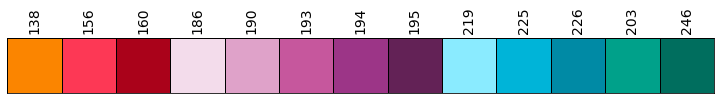

In [13]:
def plot_haplotype(haplotype_string, virus):
    """
    Plots a single row of squares based on binary haplotype (has adaptive mut at position or no)
    """
    cols = len(haplotype_string)  # The number of columns is the length of the binary string
    
    fig, ax = plt.subplots(figsize=(len(haplotype_string),1))
    ax.set_xlim(0, cols)
    ax.set_ylim(0, 1)  # Single row, so height is 1
    ax.set_aspect('equal')

    # Draw individual squares based on the binary string
    for j in range(cols):
        color = haplotype_cmap[virus][j] if haplotype_string[j] == '1' else 'white'
        rect = Rectangle((j, 0), 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        ax.text(
            j + 0.5, 1.1, str(base_haplotype_residues[virus][j]),  # Center text horizontally and position it above the box
            ha='center', va='bottom', fontsize=14, rotation=90
        )

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0) 

    
haplotype_string = ''.join(['1' for x in range(len(base_haplotypes['h3n2']))])
plot_haplotype(haplotype_string, 'h3n2')


In [14]:
def plot_muts_haplotype(haplotype_string, virus, ax):
    """
    Plots a single row of squares based on binary haplotype (has adaptive mut at position or no)
    
    Just plot the positions with muts
    """
    mut_indicies = [i for i,x in enumerate(haplotype_string) if x=='1']
    # if haplotype is just wildtype, return just one empty box
    if len(mut_indicies) == 0:
        ax = plot_parent_box(ax)
    else:
        cols = len(mut_indicies)  # The number of columns is equal to the number of sites with muts

        ax.set_xlim(0, cols)
        ax.set_ylim(0, 1)  # Single row, so height is 1
        ax.set_aspect('equal')

        # Draw individual squares for each adaptive site with mut
        for j in range(cols):
            mut_index = mut_indicies[j]
            color = haplotype_cmap[virus][mut_index]
            rect = Rectangle((j, 0), 1, 1, facecolor=color, edgecolor='black')
            ax.add_patch(rect)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis='both', which='both', length=0) 
    
    return ax

In [15]:
def plot_parent_box(ax):
    """
    """
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1) 
    ax.set_aspect('equal')

    rect = Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black')
    ax.add_patch(rect)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0) 
    
    return ax

In [17]:
def plot_all_node_replicate_by_time(virus, time_btwn_parent_egg=30.0):
    
    virus_df = replicates_w_paths(virus, time_btwn_parent_egg)
    
    #plot styling
    sns.set_style("white")
    plt.rcParams['figure.dpi']= 300
    plt.rcParams['font.family'] = 'Arial'


    # Define the number of rows and columns
    nrows = 200 
    # 3 columns of 3
    ncols = 9

    # Create a figure
    fig = plt.figure(figsize=(12, 30))

    # Create a GridSpec object with X rows and Y columns
    gs = GridSpec(nrows, ncols, figure=fig, 
                  width_ratios=[1,1,0.15, 1,1,0.15, 1,1,0.15]
                 )

    
    
    # keep track of parent count
    p_count = 0

    # intitialize these at 0, then change according to the last parent index seen in each column
    first_col_end = 0
    second_col_end = 0

    # order the df by parent date
    # Find the earliest parent_date for each parent
    earliest_parent_date = (
        virus_df.groupby('parent', as_index=False)['parent_date']
        .min()
        .sort_values('parent_date')
    )

    sorted_parents = earliest_parent_date['parent']
    virus_df_by_date = virus_df.set_index('parent').loc[sorted_parents].reset_index()


    for p in sorted_parents:
        p_df = virus_df_by_date[virus_df_by_date['parent']==p]
        parent_date = p_df['parent_date'].unique()[0]
        # assign column based on parent date 
        if parent_date < 2010:
            p_col = 0
            h_col = 1
            row_adjuster = 0
        elif parent_date >=2010 and parent_date <=2020:
            if first_col_end == 0:
                first_col_end = p_count 
            p_col = 3
            h_col = 4
            row_adjuster = first_col_end 
        else:
            if second_col_end == 0:
                second_col_end = p_count
            p_col = 6
            h_col = 7
            row_adjuster = second_col_end 


        # axis to plot parent
        ax_par = fig.add_subplot(gs[p_count-row_adjuster, p_col])
        plot_parent_box(ax_par)

        # Get the parent box center in figure coordinates
        par_bbox = ax_par.get_position(fig)
        parent_center = par_bbox.x1-0.03, (par_bbox.y0 + par_bbox.y1) / 2
        
        # add title to top row
        if p_count-row_adjuster == 0:
            if p_col ==0:
                ax_par.text(0,2.5, '1995-2009', fontsize=14)
            elif p_col ==3:
                ax_par.text(0,2.5, '2010-2019', fontsize=14)
            elif p_col ==6:
                ax_par.text(0,2.5, '2020-present', fontsize=14)


        for i, x in p_df.iterrows():
            hap= x['haplotype']
            hap_count = x['count']
            # plot the first haplotype on same row as parent
            ax_hap = fig.add_subplot(gs[p_count-row_adjuster, h_col])
            plot_muts_haplotype(hap, virus, ax_hap)

            # Get the haplotype box center in figure coordinates
            hap_bbox = ax_hap.get_position(fig)
            hap_center = hap_bbox.x0+0.02, (hap_bbox.y0 + hap_bbox.y1) / 2
            
            line_thickness = lambda x:x if x<=5 else 5

            # Draw a line between parent and child
            line = ConnectionPatch(
                xyA=parent_center,
                xyB=hap_center,
                coordsA="figure fraction",
                coordsB="figure fraction",
                arrowstyle="-",
                color="black",
                lw=line_thickness(hap_count)
            )
            fig.add_artist(line)
            

            # then next one beneath that, etc
            # increase parent count, for next parent
            p_count+=1

        # add empty row between parents
        ax_spacer = fig.add_subplot(gs[p_count-row_adjuster, p_col])
        ax_spacer.set_axis_off()
        p_count +=1
        
    



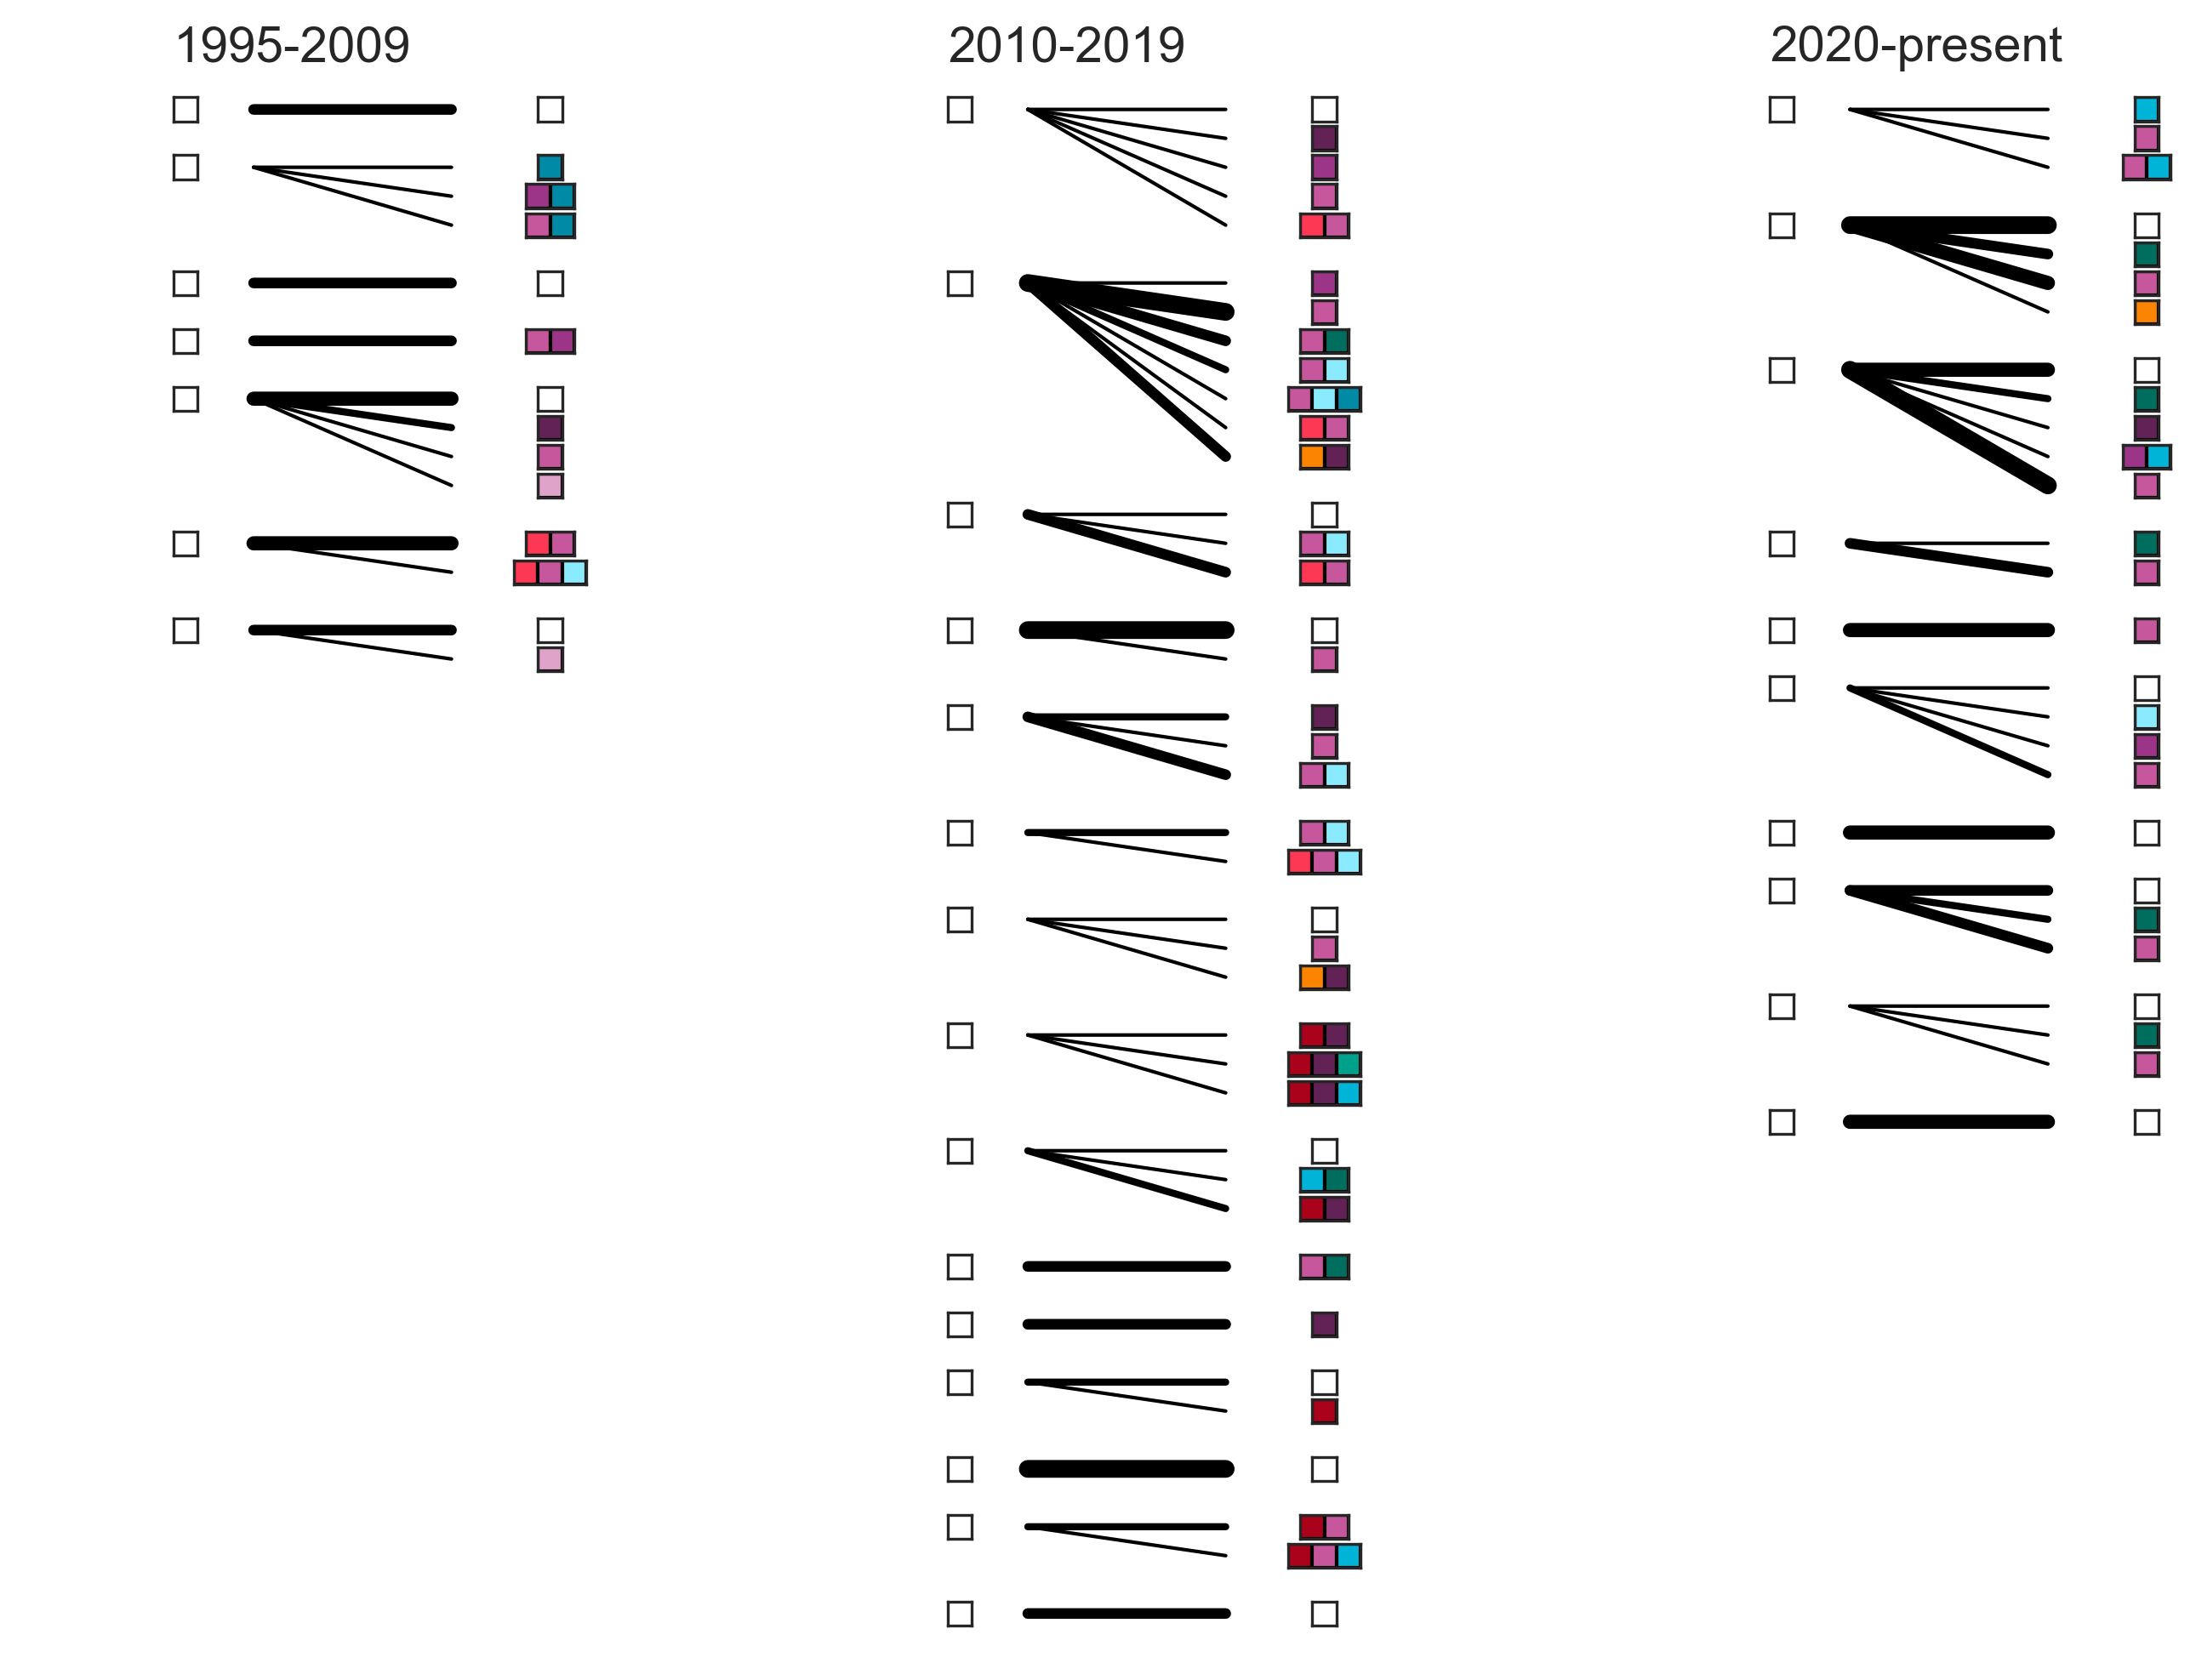

In [214]:
plot_all_node_replicate_by_time('h3n2')

In [20]:
prettify_names = {'h3n2': 'A/H3N2', 'h1n1pdm': 'A/H1N1pdm', 'vic': 'B/Vic', 'yam': 'B/Yam'}


In [52]:
def plot_all_node_replicate_condensed(virus, time_btwn_parent_egg=30.0, filename=None):
    
    virus_df = replicates_w_paths(virus, time_btwn_parent_egg)
    
    # get num rows if there was just one column (1 row per replicate plus 1 row spacer between each parent)
    total_rows = len(virus_df) + len(virus_df.groupby('parent'))
    
    # set specs for the different viruses to make plots look better
    num_columns = {'h3n2': 8, 'h1n1pdm':10, 'vic': 8, 'yam': 6}
    len_column = total_rows/(num_columns[virus]*0.5)
    line_start_offset = {'h3n2': -0.02, 'h1n1pdm': -0.02, 'vic': -0.02, 'yam': -0.03}
    line_end_offset = {'h3n2': 0.02, 'h1n1pdm': 0.02, 'vic':0.02, 'yam':0.03}

    
    #plot styling
    sns.set_style("white")
    plt.rcParams['figure.dpi']= 300
    plt.rcParams['font.family'] = 'Arial'


    # Define the number of rows and columns
    nrows = 200 
    ncols = num_columns[virus]
    width = {'h3n2': 0.8*ncols, 'h1n1pdm': ncols, 'vic': ncols, 'yam': 0.8*ncols}
    height = {'h3n2': 1.2*len_column, 'h1n1pdm': len_column, 'vic': 2*len_column, 'yam': 3*len_column}
    line_thickness_scaler = {'h3n2': 1, 'h1n1pdm': 1, 'vic': 0.5, 'yam': 0.5}

    # Create a figure
    fig = plt.figure(figsize=(width[virus], height[virus]))

    # Create a GridSpec object with X rows and Y columns
    gs = GridSpec(nrows, ncols, figure=fig)
    
    ax_title = fig.add_subplot(gs[0, 0])
    ax_title.text(0, 1.5, prettify_names[virus], fontsize=16, transform=ax_title.transAxes)
    ax_title.set_axis_off()
    
    # keep track of parent count
    # start at 1 to allow title row
    p_count = 1

    # intitialize these at 0, then change according to the last parent index seen in each column
    first_col_end = 0
    second_col_end = 0
    third_col_end = 0
    fourth_col_end = 0

    # order the df by parent date
    # Find the earliest parent_date for each parent
    earliest_parent_date = (
        virus_df.groupby('parent', as_index=False)['parent_date']
        .min()
        .sort_values('parent_date')
    )

    sorted_parents = earliest_parent_date['parent']
    virus_df_by_date = virus_df.set_index('parent').loc[sorted_parents].reset_index()
    

    for p in sorted_parents:
        p_df = virus_df_by_date[virus_df_by_date['parent']==p]
        # assign column based on parent date 
        if p_count< len_column:
            p_col = 0
            h_col = 1
            row_adjuster = 1
        elif p_count >= len_column and p_count <= 2*len_column:
            if first_col_end == 0:
                first_col_end = p_count 
            p_col = 2
            h_col = 3
            row_adjuster = first_col_end 
        elif p_count >= 2*len_column and p_count <= 3*len_column:
            if second_col_end == 0:
                second_col_end = p_count
            p_col = 4
            h_col = 5
            row_adjuster = second_col_end 
        elif p_count >= 3*len_column and p_count <= 4*len_column:
            if third_col_end == 0:
                third_col_end = p_count
            p_col = 6
            h_col = 7
            row_adjuster = third_col_end 
        elif p_count >= 4*len_column and p_count <= 5*len_column:
            if fourth_col_end == 0:
                fourth_col_end = p_count
            p_col = 8
            h_col = 9
            row_adjuster = fourth_col_end 


        # axis to plot parent
        ax_par = fig.add_subplot(gs[p_count-row_adjuster, p_col])
        plot_parent_box(ax_par)
#         ax_par.text(0.5, 0.5, str(p), ha='center', va='center', fontsize=10, fontweight='bold', transform=ax_par.transAxes)


        # Get the parent box center in figure coordinates
        par_bbox = ax_par.get_position(fig)
        parent_center = par_bbox.x1+line_start_offset[virus], (par_bbox.y0 + par_bbox.y1) / 2
        

        for i, x in p_df.iterrows():
            hap= x['haplotype']
            hap_count = x['count']
            # plot the first haplotype on same row as parent
            ax_hap = fig.add_subplot(gs[p_count-row_adjuster, h_col])
            plot_muts_haplotype(hap, virus, ax_hap)

            # Get the haplotype box center in figure coordinates
            hap_bbox = ax_hap.get_position(fig)
            hap_center = hap_bbox.x0+line_end_offset[virus], (hap_bbox.y0 + hap_bbox.y1) / 2
            
            line_thickness = lambda x:x if x<=5 else 5
#             line_thickness = line_thickness * (height[virus]/height['h3n2'])

            # Draw a line between parent and child
            line = ConnectionPatch(
                xyA=parent_center,
                xyB=hap_center,
                coordsA="figure fraction",
                coordsB="figure fraction",
                arrowstyle="-",
                color="black",
                lw=line_thickness(hap_count)* line_thickness_scaler[virus]
            )
            fig.add_artist(line)
            

            # then next one beneath that, etc
            # increase parent count, for next parent
            p_count+=1

        # add empty row between parents
        ax_spacer = fig.add_subplot(gs[p_count-row_adjuster, p_col])
        ax_spacer.set_axis_off()
        p_count +=1
    
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')

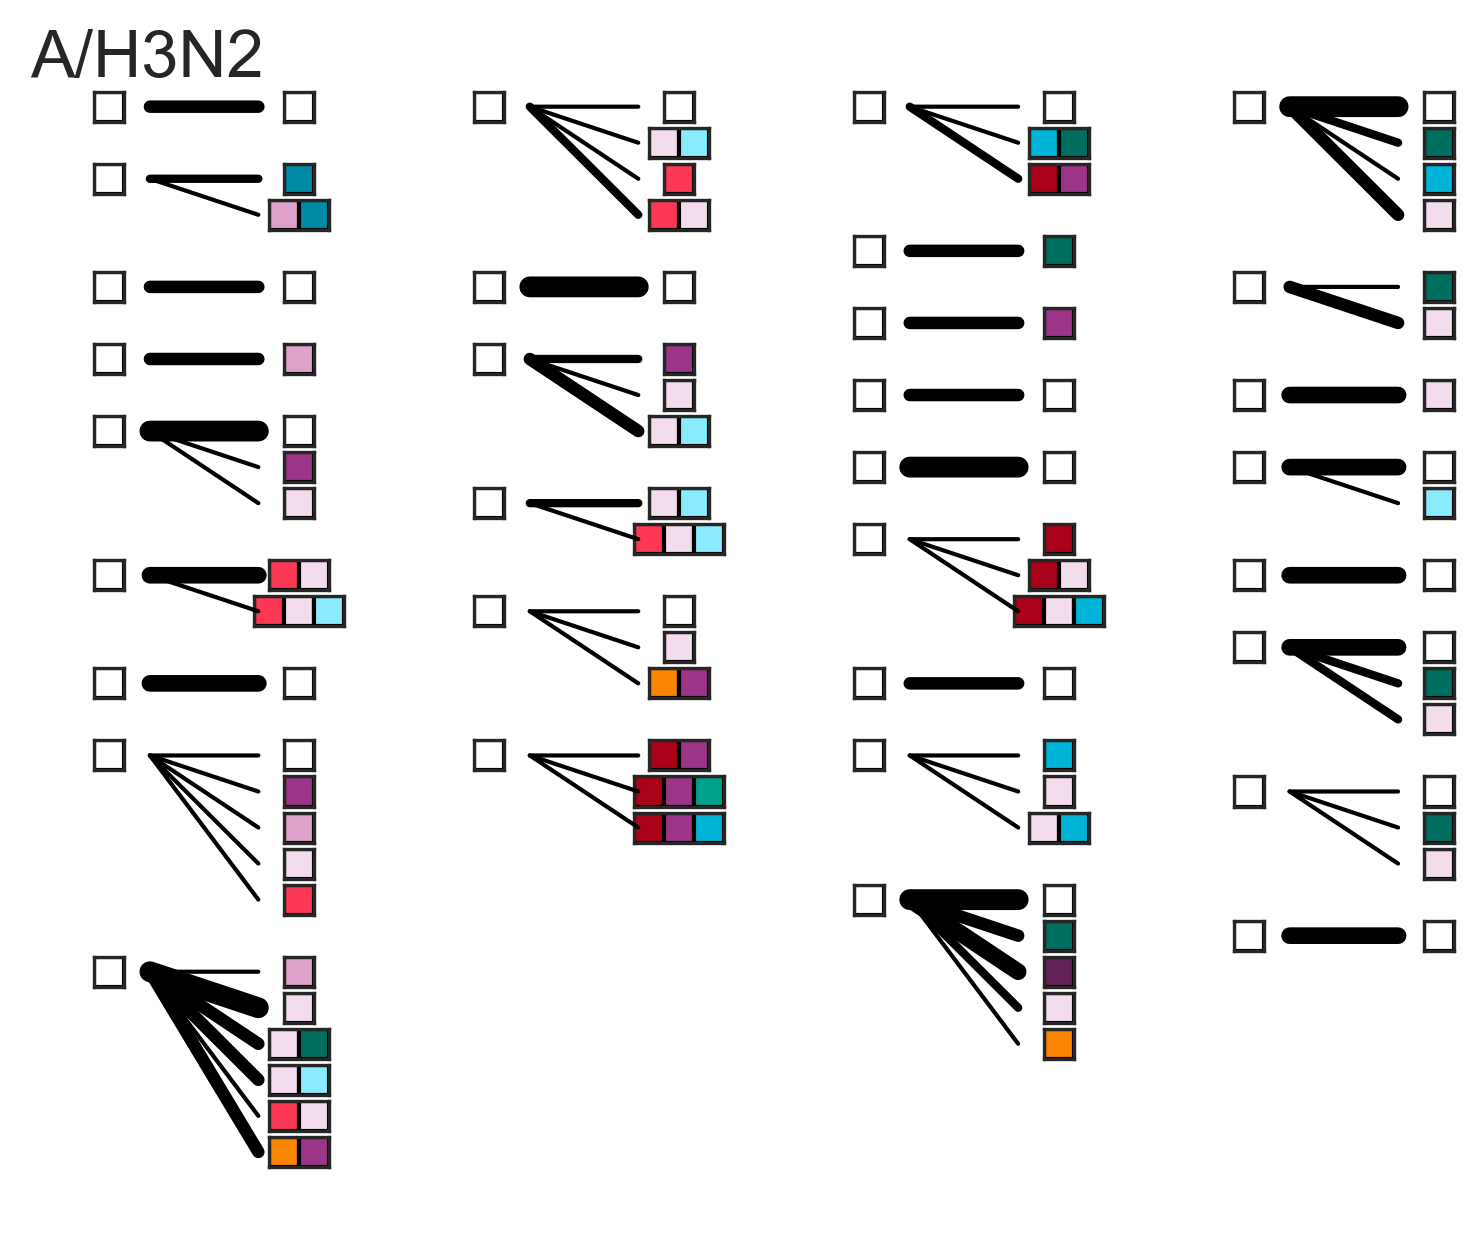

In [41]:
plot_all_node_replicate_condensed('h3n2', filename='Supplement-replicateSets/h3n2_reps.png')

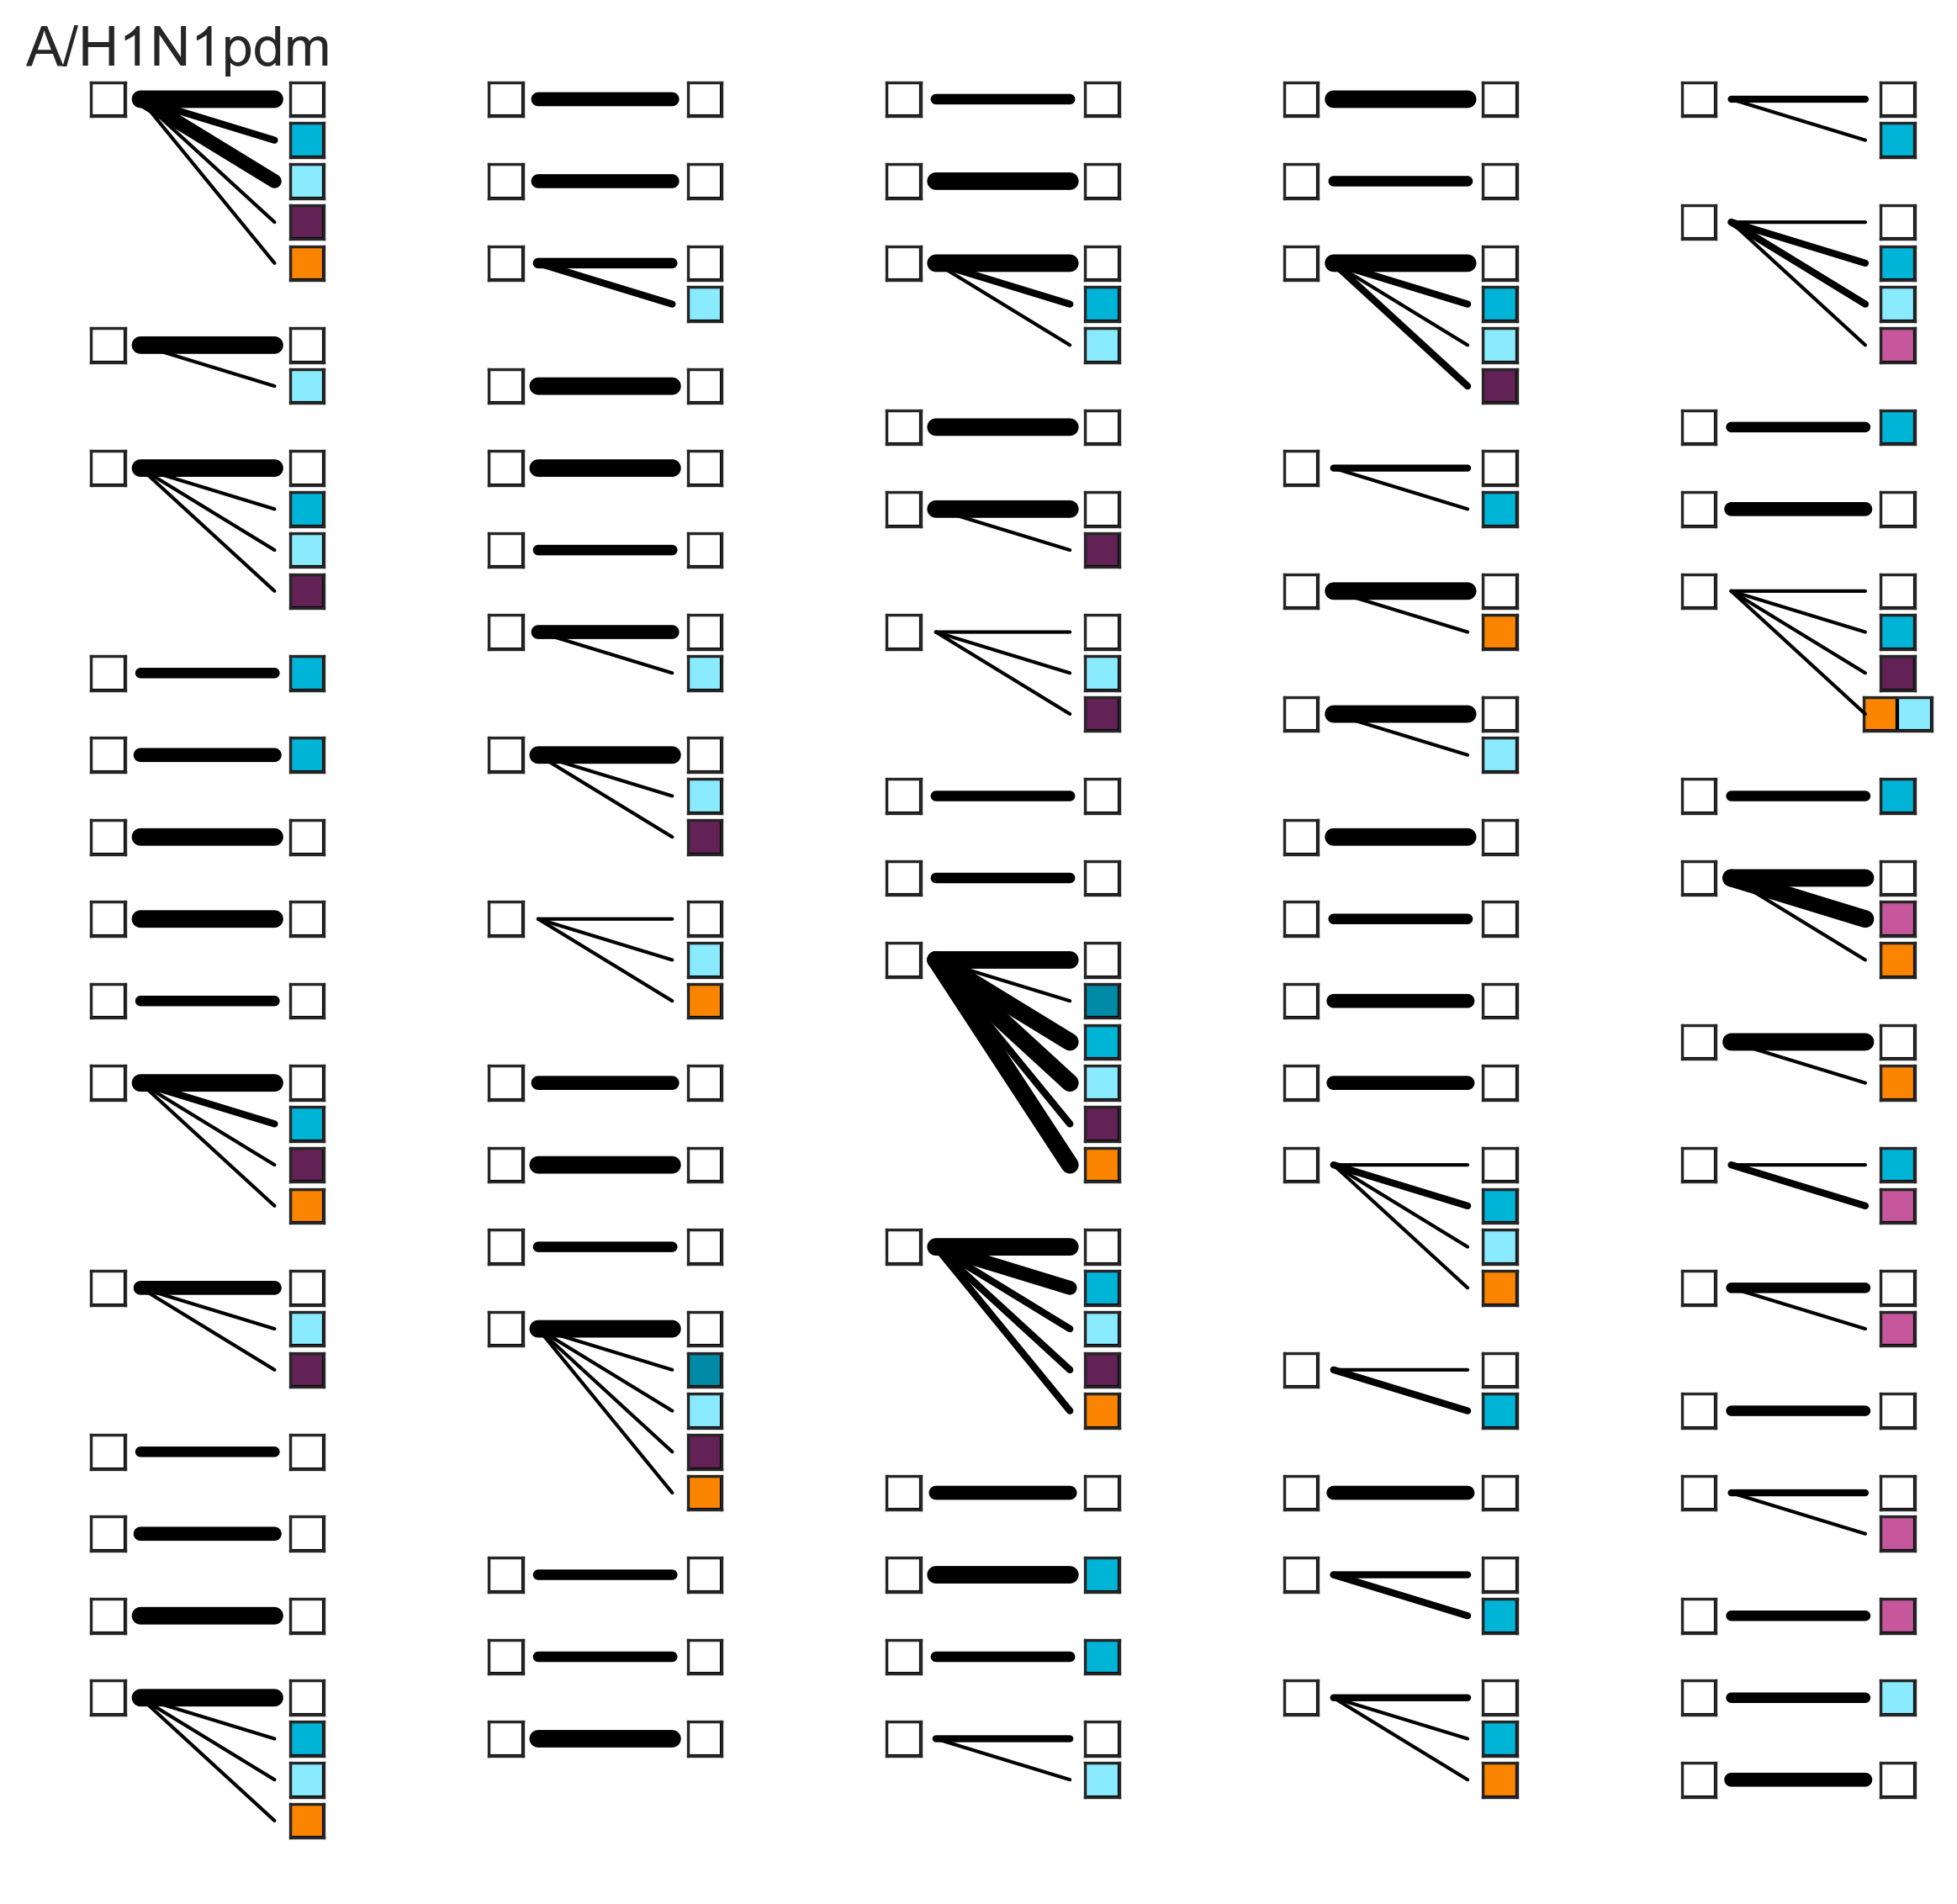

In [36]:
plot_all_node_replicate_condensed('h1n1pdm', filename='Supplement-replicateSets/h1n1pdm_reps.png')

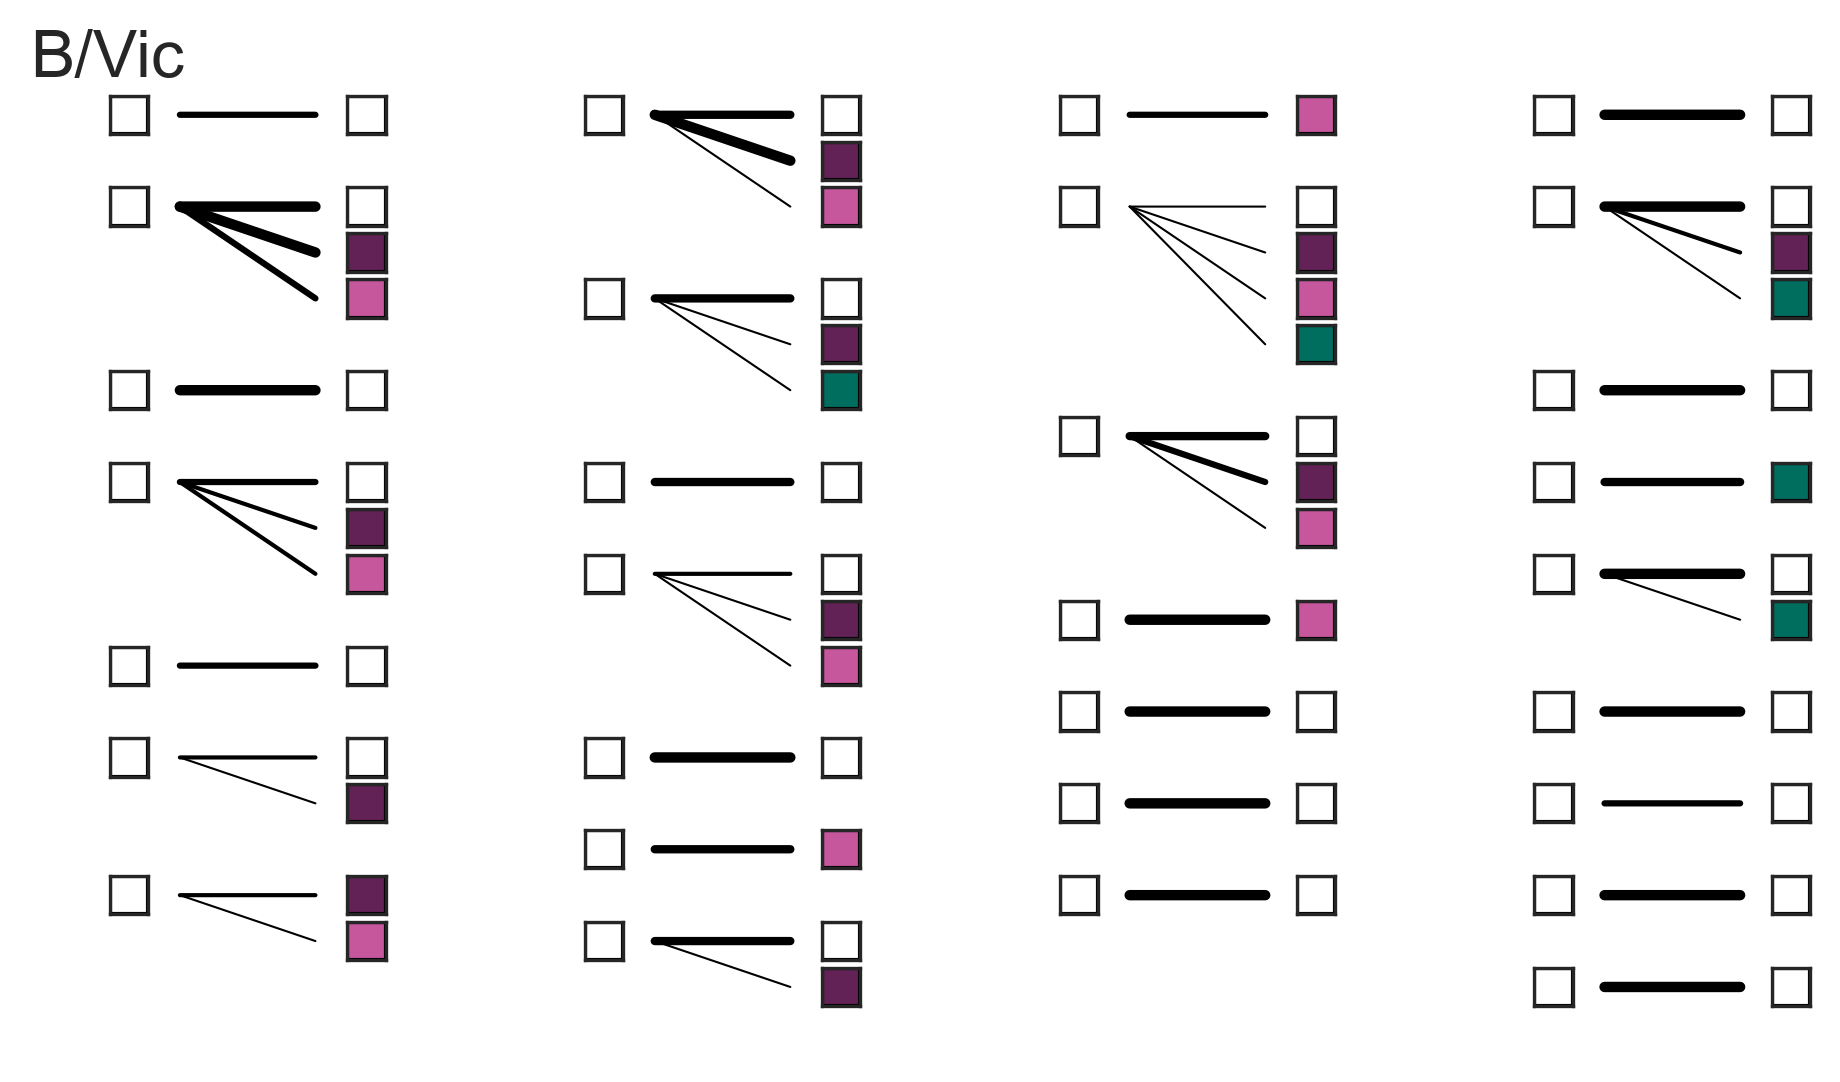

In [37]:
plot_all_node_replicate_condensed('vic', filename='Supplement-replicateSets/vic_reps.png')

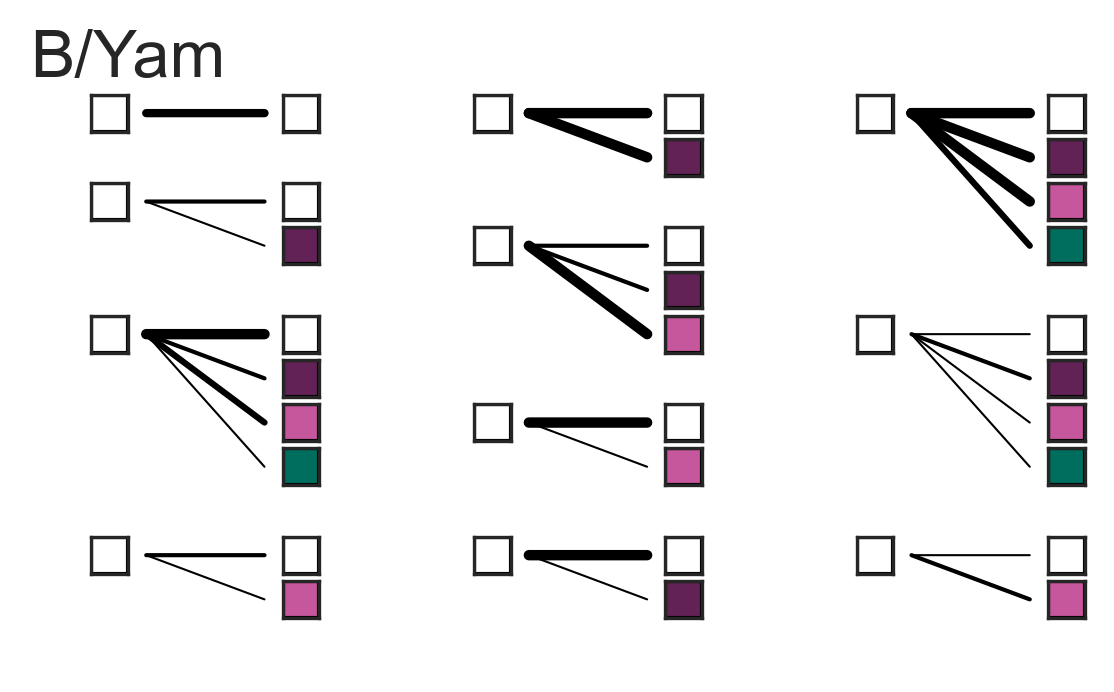

In [38]:
plot_all_node_replicate_condensed('yam', filename='Supplement-replicateSets/yam_reps.png')

In [53]:
# if there is evidence of "intermediate" within the set, group them in one pathway
h3n2_num_pathways = {'NODE_0000856': 0, 'NODE_0005473': 1, 'NODE_0000960': 0, 'NODE_0005353': 1, 
                'NODE_0006477': 2, 'NODE_0006696': 1, 'NODE_0008516': 0, 'NODE_0002314': 4, 
                'NODE_0002373': 3, 'NODE_0009142': 1, 'NODE_0007938': 0, 'NODE_0009324': 2, 
                'NODE_0009220': 1, 'NODE_0002589': 2, 'NODE_0010668': 1, 'NODE_0011144': 2, 
                'NODE_0009776': 1, 'NODE_0011336': 1, 'NODE_0011393': 0, 'NODE_0011034': 0, 
                'NODE_0003646': 1, 'NODE_0013053': 0, 'NODE_0004152': 1, 'NODE_0004263': 4, 
                'NODE_0004402': 3, 'NODE_0013605': 2, 'NODE_0013529': 1, 'NODE_0004518': 1, 
                'NODE_0013322': 0, 'NODE_0014983': 2, 'NODE_0013629': 2, 'NODE_0013971': 0}

In [54]:
h3n2_has_intermediate = {'NODE_0000856': 0, 'NODE_0005473': 1, 'NODE_0000960': 0, 'NODE_0005353': 0, 
                    'NODE_0006477': 0, 'NODE_0006696': 1, 'NODE_0008516': 0, 'NODE_0002314': 0, 
                    'NODE_0002373': 1, 'NODE_0009142': 1, 'NODE_0007938': 0, 'NODE_0009324': 1, 
                    'NODE_0009220': 1, 'NODE_0002589': 0, 'NODE_0010668': 1, 'NODE_0011144': 0, 
                    'NODE_0009776': 0, 'NODE_0011336': 0, 'NODE_0011393': 0, 'NODE_0011034': 0, 
                    'NODE_0003646': 1, 'NODE_0013053': 0, 'NODE_0004152': 1, 'NODE_0004263': 0, 
                    'NODE_0004402': 0, 'NODE_0013605': 0, 'NODE_0013529': 0, 'NODE_0004518': 0, 
                    'NODE_0013322': 0, 'NODE_0014983': 0, 'NODE_0013629': 0, 'NODE_0013971': 0}

In [55]:
h1n1pdm_num_pathways = {'NODE_0000416': 4, 'NODE_0000057': 1, 'NODE_0000647': 3, 'NODE_0000253': 1, 
                            'NODE_0000239': 1, 'NODE_0004967': 0, 'NODE_0000277': 0, 'NODE_0005549': 0, 
                            'NODE_0001155': 3, 'NODE_0000135': 2, 'NODE_0005502': 0, 'NODE_0002462': 0, 
                            'NODE_0003281': 0, 'NODE_0004716': 3, 'NODE_0002446': 0, 'NODE_0002487': 0, 
                            'NODE_0004179': 1, 'NODE_0000248': 0, 'NODE_0005105': 0, 'NODE_0000335': 0, 
                            'NODE_0003221': 1, 'NODE_0006551': 2, 'NODE_0000101': 2, 'NODE_0003768': 0, 
                            'NODE_0000591': 0, 'NODE_0000126': 0, 'NODE_0000775': 4, 'NODE_0005765': 0, 
                            'NODE_0005671': 0, 'NODE_0005777': 0, 'NODE_0000451': 0, 'NODE_0005891': 0, 
                            'NODE_0001036': 2, 'NODE_0006511': 0, 'NODE_0000359': 1, 'NODE_0000668': 2, 
                            'NODE_0006844': 0, 'NODE_0007097': 0, 'NODE_0001826': 5, 'NODE_0008931': 4, 
                            'NODE_0007157': 0, 'NODE_0007365': 1, 'NODE_0007252': 1, 'NODE_0009516': 1, 
                            'NODE_0007671': 0, 'NODE_0009029': 0, 'NODE_0001985': 3, 'NODE_0002302': 1, 
                            'NODE_0009586': 1, 'NODE_0008430': 1, 'NODE_0008408': 0, 'NODE_0007165': 0, 
                            'NODE_0008405': 0, 'NODE_0010714': 0, 'NODE_0012426': 3, 'NODE_0003186': 1, 
                            'NODE_0010187': 0, 'NODE_0003102': 1, 'NODE_0002992': 2, 'NODE_0002772': 1, 
                            'NODE_0011206': 3, 'NODE_0010516': 1, 'NODE_0010881': 0, 'NODE_0011060': 3, 
                            'NODE_0003438': 1, 'NODE_0003607': 2, 'NODE_0013530': 1, 'NODE_0003832': 2, 
                            'NODE_0012086': 1, 'NODE_0014472': 0, 'NODE_0003691': 1, 'NODE_0015715': 1, 
                            'NODE_0013960': 1, 'NODE_0014343': 0}

In [56]:
h1n1pdm_has_intermediate = {'NODE_0000416': 0, 'NODE_0000057': 0, 'NODE_0000647': 0, 'NODE_0000253': 0, 
                            'NODE_0000239': 0, 'NODE_0004967': 0, 'NODE_0000277': 0, 'NODE_0005549': 0, 
                            'NODE_0001155': 0, 'NODE_0000135': 0, 'NODE_0005502': 0, 'NODE_0002462': 0, 
                            'NODE_0003281': 0, 'NODE_0004716': 0, 'NODE_0002446': 0, 'NODE_0002487': 0, 
                            'NODE_0004179': 0, 'NODE_0000248': 0, 'NODE_0005105': 0, 'NODE_0000335': 0, 
                            'NODE_0003221': 0, 'NODE_0006551': 0, 'NODE_0000101': 0, 'NODE_0003768': 0, 
                            'NODE_0000591': 0, 'NODE_0000126': 0, 'NODE_0000775': 0, 'NODE_0005765': 0, 
                            'NODE_0005671': 0, 'NODE_0005777': 0, 'NODE_0000451': 0, 'NODE_0005891': 0, 
                            'NODE_0001036': 0, 'NODE_0006511': 0, 'NODE_0000359': 0, 'NODE_0000668': 0, 
                            'NODE_0006844': 0, 'NODE_0007097': 0, 'NODE_0001826': 0, 'NODE_0008931': 0, 
                            'NODE_0007157': 0, 'NODE_0007365': 0, 'NODE_0007252': 0, 'NODE_0009516': 0, 
                            'NODE_0007671': 0, 'NODE_0009029': 0, 'NODE_0001985': 0, 'NODE_0002302': 0, 
                            'NODE_0009586': 0, 'NODE_0008430': 0, 'NODE_0008408': 0, 'NODE_0007165': 0, 
                            'NODE_0008405': 0, 'NODE_0010714': 0, 'NODE_0012426': 0, 'NODE_0003186': 0, 
                            'NODE_0010187': 0, 'NODE_0003102': 0, 'NODE_0002992': 0, 'NODE_0002772': 0, 
                            'NODE_0011206': 0, 'NODE_0010516': 0, 'NODE_0010881': 0, 'NODE_0011060': 0, 
                            'NODE_0003438': 0, 'NODE_0003607': 0, 'NODE_0013530': 0, 'NODE_0003832': 0, 
                            'NODE_0012086': 0, 'NODE_0014472': 0, 'NODE_0003691': 0, 'NODE_0015715': 0, 
                            'NODE_0013960': 0, 'NODE_0014343': 0}

In [57]:
vic_num_pathways = {'NODE_0000215': 0, 'NODE_0000344': 2, 'NODE_0002550': 0, 'NODE_0001309': 2, 
                        'NODE_0005989': 0, 'NODE_0006096': 1, 'NODE_0001252': 2, 'NODE_0001446': 2, 
                        'NODE_0002044': 2, 'NODE_0002504': 0, 'NODE_0008326': 2, 'NODE_0007972': 0, 
                        'NODE_0008385': 1, 'NODE_0008092': 1, 'NODE_0009173': 1, 'NODE_0008806': 3, 
                        'NODE_0008201': 2, 'NODE_0009179': 1, 'NODE_0011127': 0, 'NODE_0011703': 0, 
                        'NODE_0011161': 0, 'NODE_0003647': 0, 'NODE_0003859': 2, 'NODE_0010842': 0, 
                        'NODE_0010949': 1, 'NODE_0003983': 1, 'NODE_0011191': 0, 'NODE_0012962': 0, 
                        'NODE_0012783': 0, 'NODE_0004450': 0}

In [58]:
vic_has_intermediate = {'NODE_0000215': 0, 'NODE_0000344': 0, 'NODE_0002550': 0, 'NODE_0001309': 0, 
                        'NODE_0005989': 0, 'NODE_0006096': 0, 'NODE_0001252': 0, 'NODE_0001446': 0, 
                        'NODE_0002044': 0, 'NODE_0002504': 0, 'NODE_0008326': 0, 'NODE_0007972': 0, 
                        'NODE_0008385': 0, 'NODE_0008092': 0, 'NODE_0009173': 0, 'NODE_0008806': 0, 
                        'NODE_0008201': 0, 'NODE_0009179': 0, 'NODE_0011127': 0, 'NODE_0011703': 0, 
                        'NODE_0011161': 0, 'NODE_0003647': 0, 'NODE_0003859': 0, 'NODE_0010842': 0, 
                        'NODE_0010949': 0, 'NODE_0003983': 0, 'NODE_0011191': 0, 'NODE_0012962': 0, 
                        'NODE_0012783': 0, 'NODE_0004450': 0}

In [59]:
yam_num_pathways = {'NODE_0001137': 0, 'NODE_0001607': 1, 'NODE_0000755': 3, 'NODE_0001521': 1, 
                        'NODE_0001537': 1, 'NODE_0000539': 2, 'NODE_0002104': 1, 'NODE_0002080': 1, 
                        'NODE_0009799': 3, 'NODE_0002735': 3, 'NODE_0003129': 1}

In [60]:
yam_has_intermediate = {'NODE_0001137': 0, 'NODE_0001607': 0, 'NODE_0000755': 0, 'NODE_0001521': 0, 
                        'NODE_0001537': 0, 'NODE_0000539': 0, 'NODE_0002104': 0, 'NODE_0002080': 0, 
                        'NODE_0009799': 0, 'NODE_0002735': 0, 'NODE_0003129': 0}

In [64]:
# aggregate all of these into one lookup dict
num_pathways = {'h3n2': h3n2_num_pathways, 'h1n1pdm': h1n1pdm_num_pathways, 
                'vic': vic_num_pathways, 'yam': yam_num_pathways}
has_intermediate = {'h3n2': h3n2_has_intermediate, 'h1n1pdm': h1n1pdm_has_intermediate, 
                    'vic': vic_has_intermediate, 'yam': yam_has_intermediate}

In [212]:
summary_data_to_plot = []

viruses = ['h3n2', 'h1n1pdm', 'vic', 'yam']
for v in viruses:
    test = replicates_w_paths(v, 30.0)
    
    for p, rs in test.groupby('parent'):
        total_reps = rs['count'].sum()
#         if total_reps <= 50:
        num_pathways_from_this_parent = num_pathways[v][p]
        intermediates_within_the_reps = has_intermediate[v][p]
        # number of different muts seen amongst replicates
        all_haps = list(rs['haplotype'])
        num_diff_muts = sum('1' in x for x in zip(*all_haps))
        if num_pathways_from_this_parent == num_diff_muts:
            color_mapper = f'{v}_1'
        else:
            color_mapper = f'{v}_0'
        summary_data_to_plot.append({'virus': v, 'parent_node': p, 
                                     'total_reps': total_reps, 
                                     'num_pathways_from_this_parent': num_pathways_from_this_parent, 
                                     'intermediates_within_the_reps': intermediates_within_the_reps, 
                                     'num_diff_muts': num_diff_muts, 'color_mapper': color_mapper})

summary_df = pd.DataFrame(summary_data_to_plot)

In [215]:
tree_path= f'../nextstrain_builds/egg-enriched/10000tips/auspice/h1n1pdm_30y_egg_ha.json'

#read in the tree
with open(tree_path, 'r') as f:
    tree_json = json.load(f)

#put tree in Bio.phylo format
tree = json_to_tree(tree_json)

for node in tree.find_clades():
    if node.name == 'NODE_0000416':
        print(node.get_terminals())

[Clade(branch_length=0.0039, name='A/Austria/242/2009-egg'), Clade(branch_length=0.00623, name='A/Japan/AF2319/2010'), Clade(branch_length=0.00818, name='A/Austria/74/2009-egg'), Clade(branch_length=0.00414, name='A/Austria/247/2009-egg'), Clade(branch_length=0.0039, name='A/Lebanon/9L-15/2009'), Clade(branch_length=0.00563, name='A/Nagasaki/HA-10-13/2010'), Clade(branch_length=0.00735, name='A/Wisconsin/4/2010-egg'), Clade(branch_length=0.00851, name='A/Guangdong/312/2010'), Clade(branch_length=0.00895, name='A/Cameroon/LEID/01/11/1467/2011'), Clade(branch_length=0.0124, name='A/Nigeria/4280/2011'), Clade(branch_length=0.00951, name='A/Cameroon/LEID/01/11/1450/2011'), Clade(branch_length=0.00893, name='A/Cameroon/LEID/01/11/1398/2010'), Clade(branch_length=0.00893, name='A/Cameroon/LEID-01-11-1398/2011'), Clade(branch_length=0.0176, name='A/Nigeria/7781/2012'), Clade(branch_length=0.0127, name='A/Hevecam/11V-19274GVFI/2011'), Clade(branch_length=0.0112, name='A/Yopougon/GR276/2012'), 

In [214]:
summary_df[(summary_df['virus']=='h1n1pdm')&(summary_df['total_reps']>50)]

,virus,parent_node,total_reps,num_pathways_from_this_parent,intermediates_within_the_reps,num_diff_muts,color_mapper
42,h1n1pdm,NODE_0000416,223,4,0,4,h1n1pdm_1
45,h1n1pdm,NODE_0000647,75,3,0,3,h1n1pdm_1


/Users/katekistler/opt/miniconda3/envs/nextstrain/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


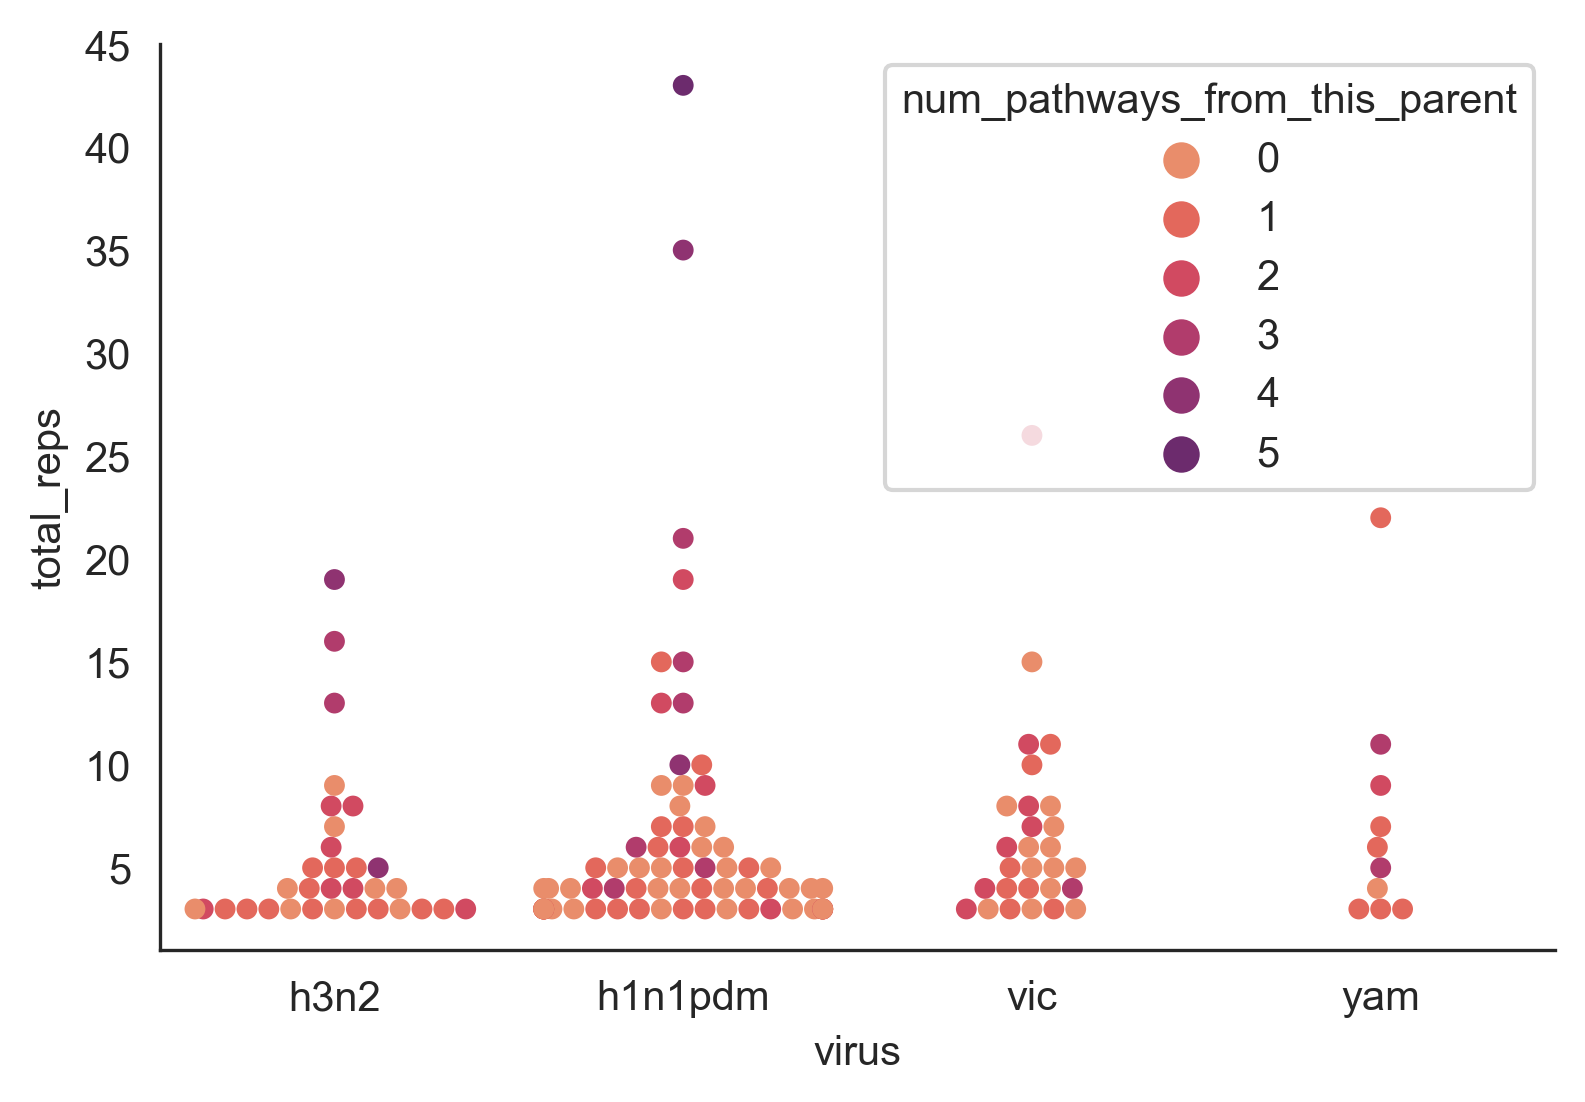

In [131]:
sns.swarmplot(data = summary_df, x='virus', y='total_reps', hue='num_pathways_from_this_parent', palette='flare')
sns.despine()

In [152]:
pathway_cmap = {'h3n2_1':'#a2dafe', 'h3n2_0': '#45b6fe', 'h1n1pdm_1': '#a986d5', 'h1n1pdm_0': '#6C3BAA', 
                'vic_1': '#ffa27f', 'vic_0': '#FF4500', 'yam_1': '#fde39d', 'yam_0': '#fbba0a'}

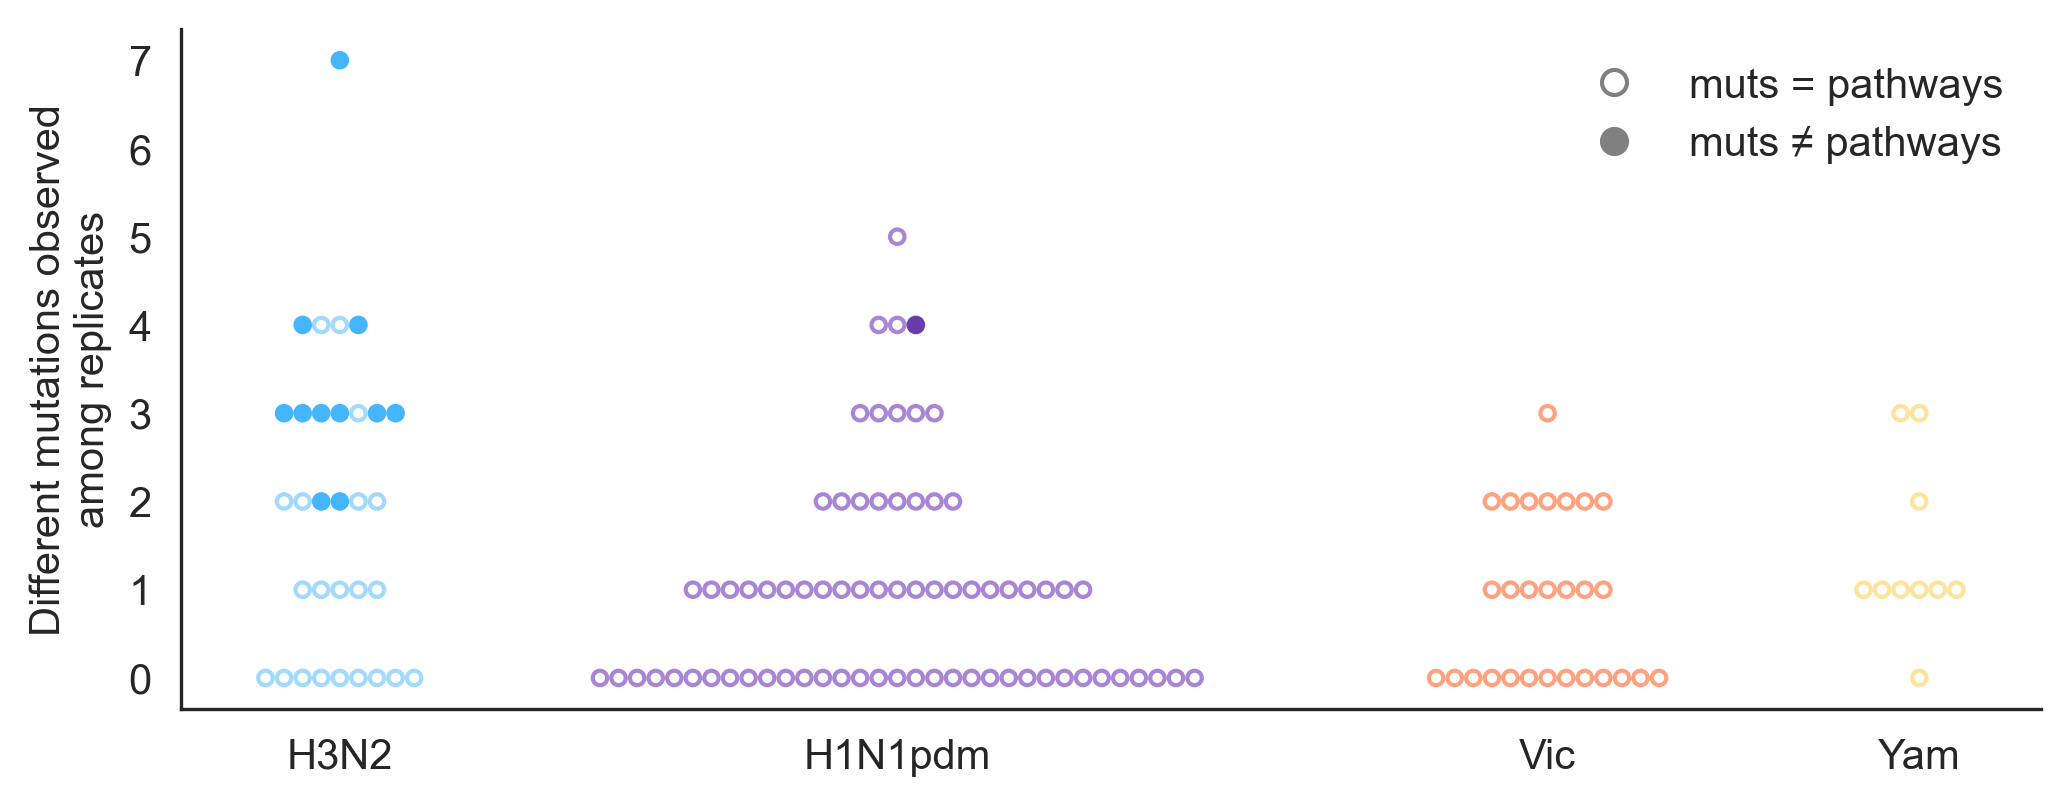

In [208]:
fig, ax = plt.subplots(figsize=(8,3))

distance_between_viruses = {'h3n2': 2, 'h1n1pdm': 8, 'vic': 15, 'yam': 19}

x_vals = []
y_vals = []
color_vals = []
edgecolor_vals = []

for i,v in enumerate(['h3n2', 'h1n1pdm', 'vic', 'yam']):
    
    v_df = summary_df[summary_df['virus']==v]
    
    x_start = 1 + distance_between_viruses[v]
    
    for n, rs in v_df.groupby('num_diff_muts'):
        # how many dots have already been plotted at this y value
        dot_counter = 0
        dot_valence = 'pos'

        for c, r in rs.iterrows():
            if dot_valence == 'pos':
                x_vals.append(x_start+dot_counter)
                dot_valence = 'neg'
                dot_counter+=0.2
            elif dot_valence == 'neg':
                x_vals.append(x_start-dot_counter)
                dot_valence = 'pos'
            y_vals.append(r['num_diff_muts'])
            # color based on whether number of pathways is also number of muts
            color = 'white' if r['color_mapper'].endswith('_1') else pathway_cmap[r['color_mapper']]
            edgecolor = pathway_cmap[r['color_mapper']]
            
            color_vals.append(color)
            edgecolor_vals.append(edgecolor)
            
            

ax.scatter(x_vals, y_vals, s=12, c=color_vals, edgecolors=edgecolor_vals)


# set x-axis labels to the virus names
custom_positions = [3, 9, 16, 20]
custom_labels = ['H3N2', 'H1N1pdm', 'Vic', 'Yam']

ax.set_xticks(custom_positions)
ax.set_xticklabels(custom_labels)

ax.set_ylabel('Different mutations observed\namong replicates')

# legend
# Define custom legend handles with circular markers
legend_handles = [
    mlines.Line2D([], [], marker='o', markersize=6, color='#808080', markerfacecolor='white', markeredgecolor='grey', linestyle='None', label='muts = pathways'),
    mlines.Line2D([], [], marker='o', markersize=6, color='#808080', markerfacecolor='#808080', markeredgecolor='grey', linestyle='None', label='muts ≠ pathways')
]

# Add legend to upper right corner
ax.legend(handles=legend_handles, loc='upper right', title=None, frameon=False)

sns.despine()

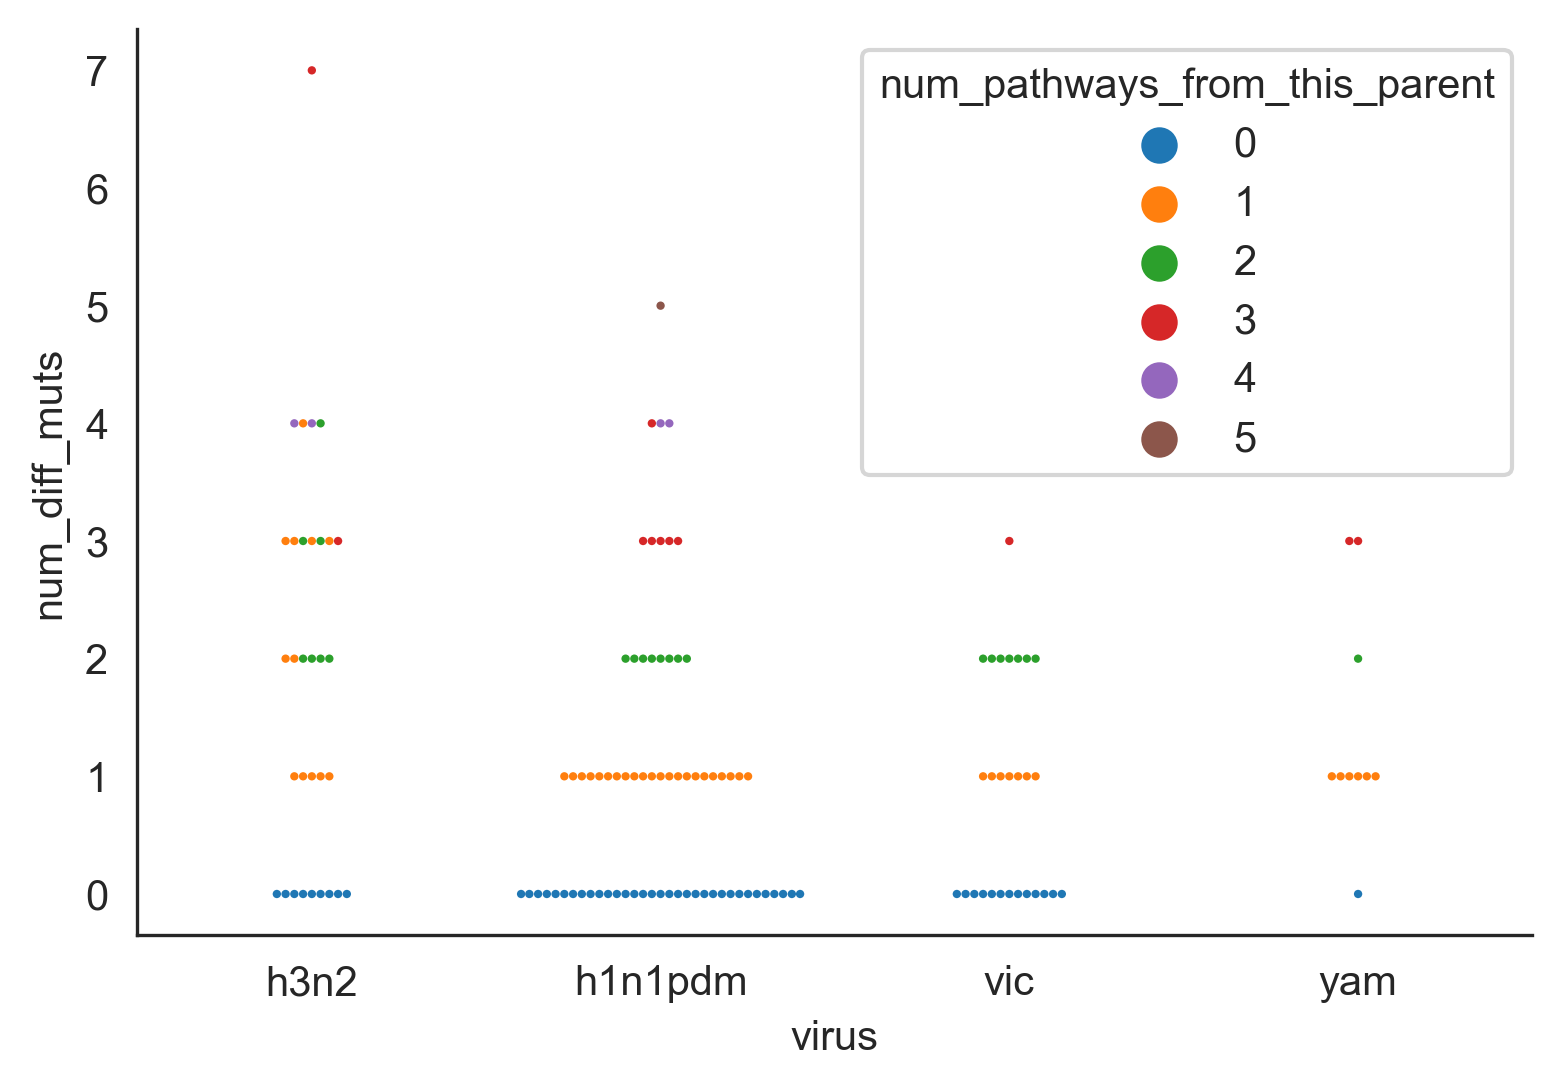

In [161]:
fig, ax = plt.subplots()
sns.swarmplot(data = summary_df, x='virus', y='num_diff_muts', 
              hue='num_pathways_from_this_parent', size=2, ax=ax)
sns.despine()

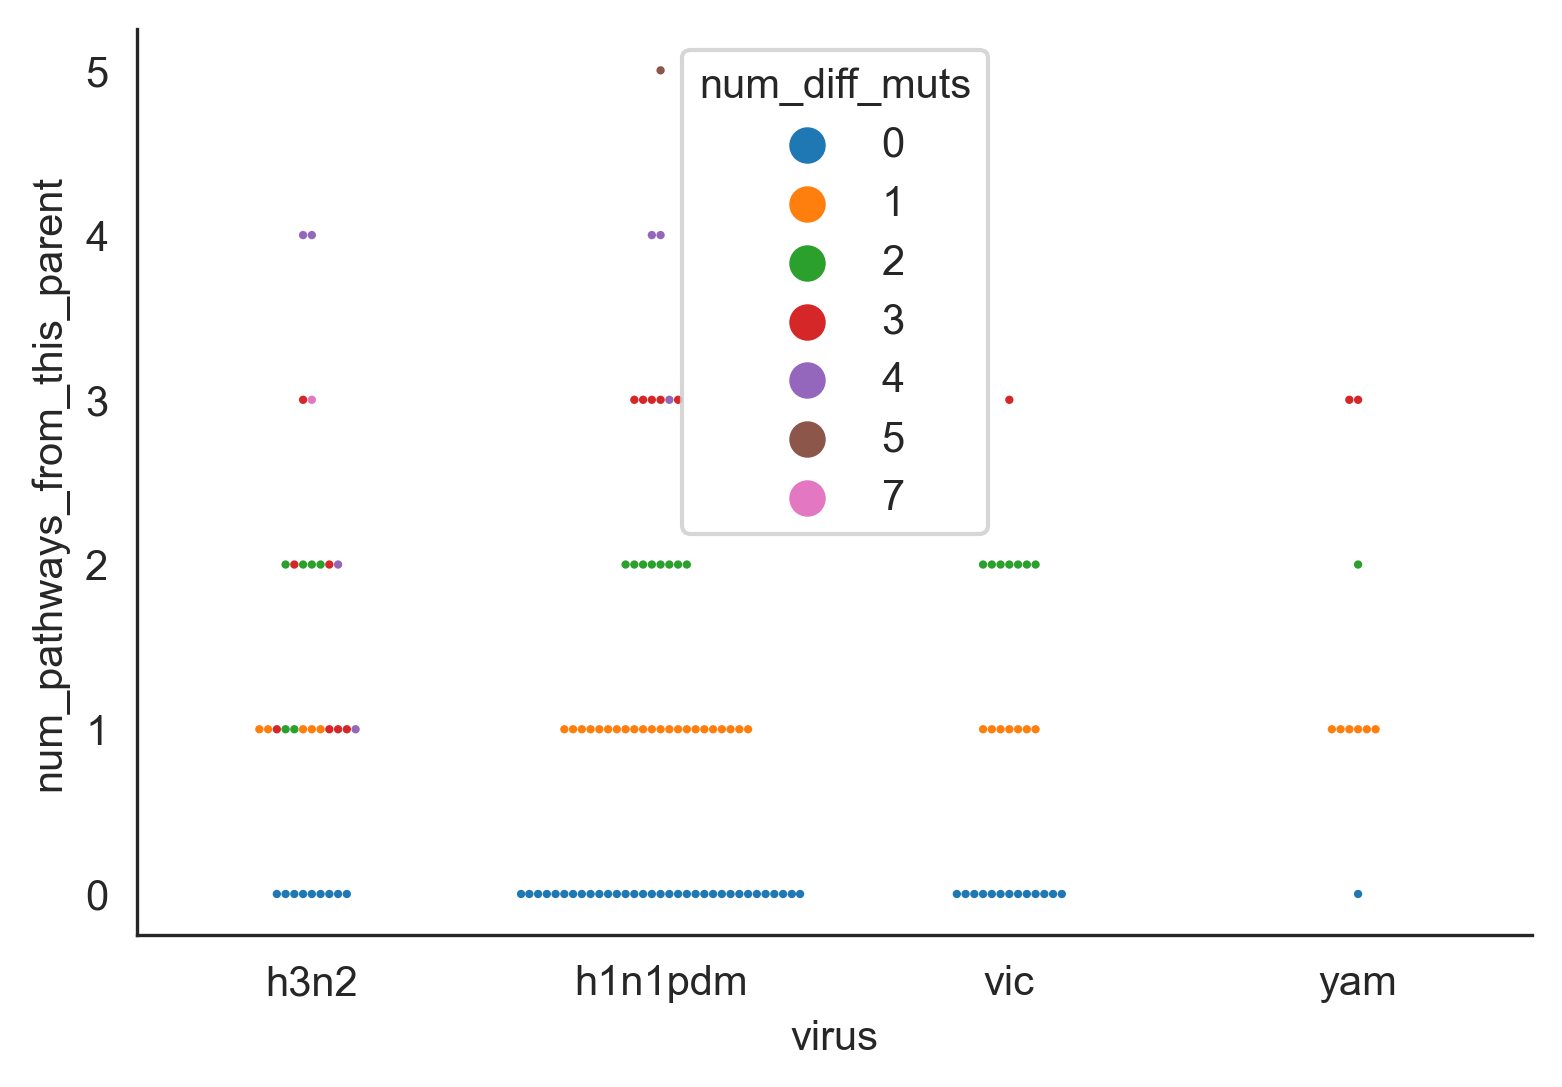

In [138]:
sns.swarmplot(data = summary_df, x='virus', y='num_pathways_from_this_parent', hue='num_diff_muts', size=2)
sns.despine()

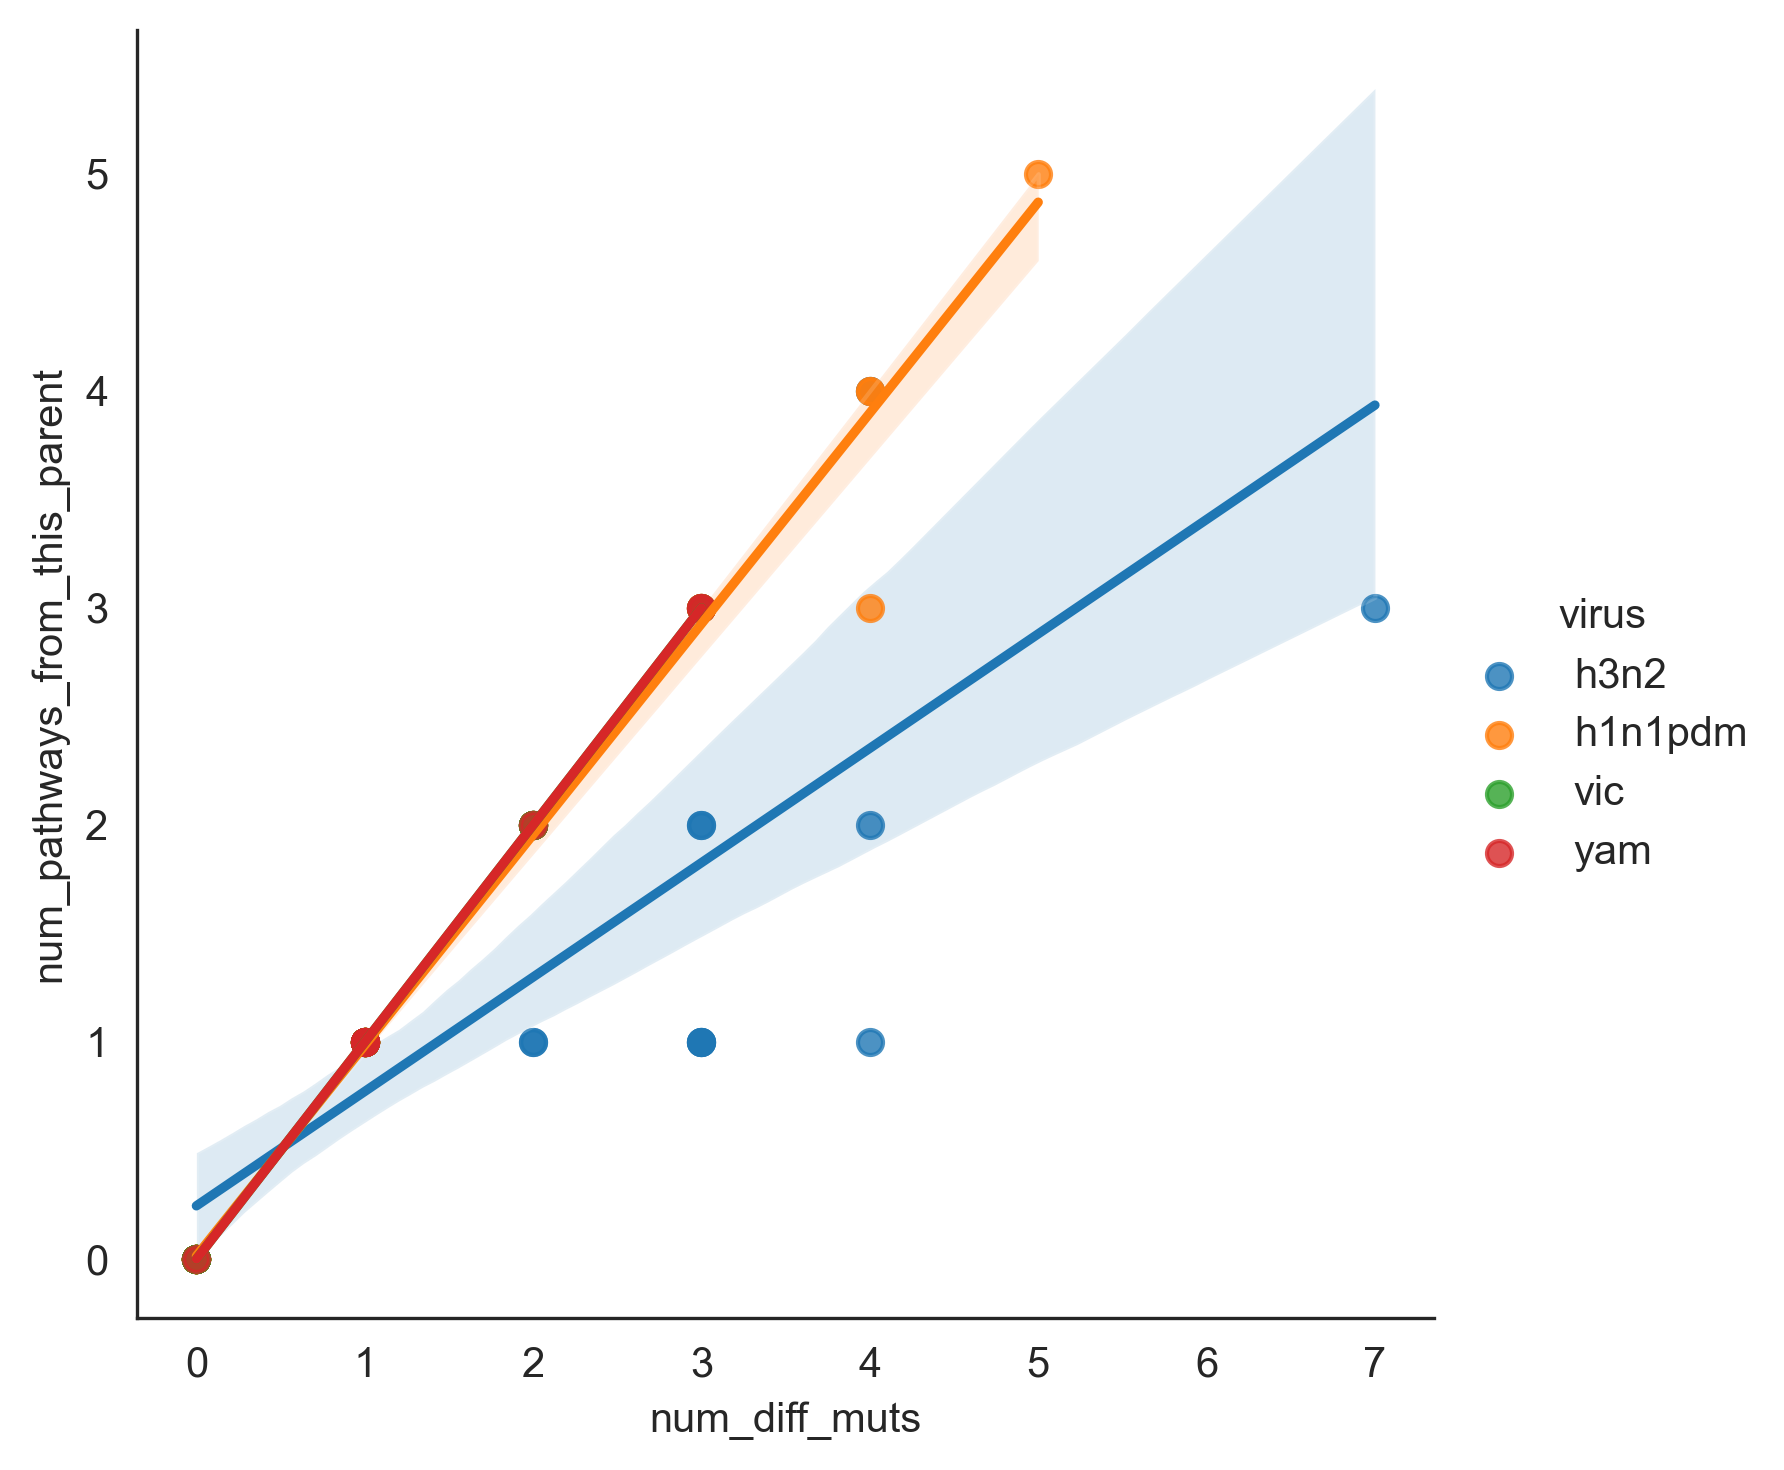

In [134]:
sns.lmplot(data = summary_df, x= 'num_diff_muts', y= 'num_pathways_from_this_parent', hue = 'virus')

sns.despine()

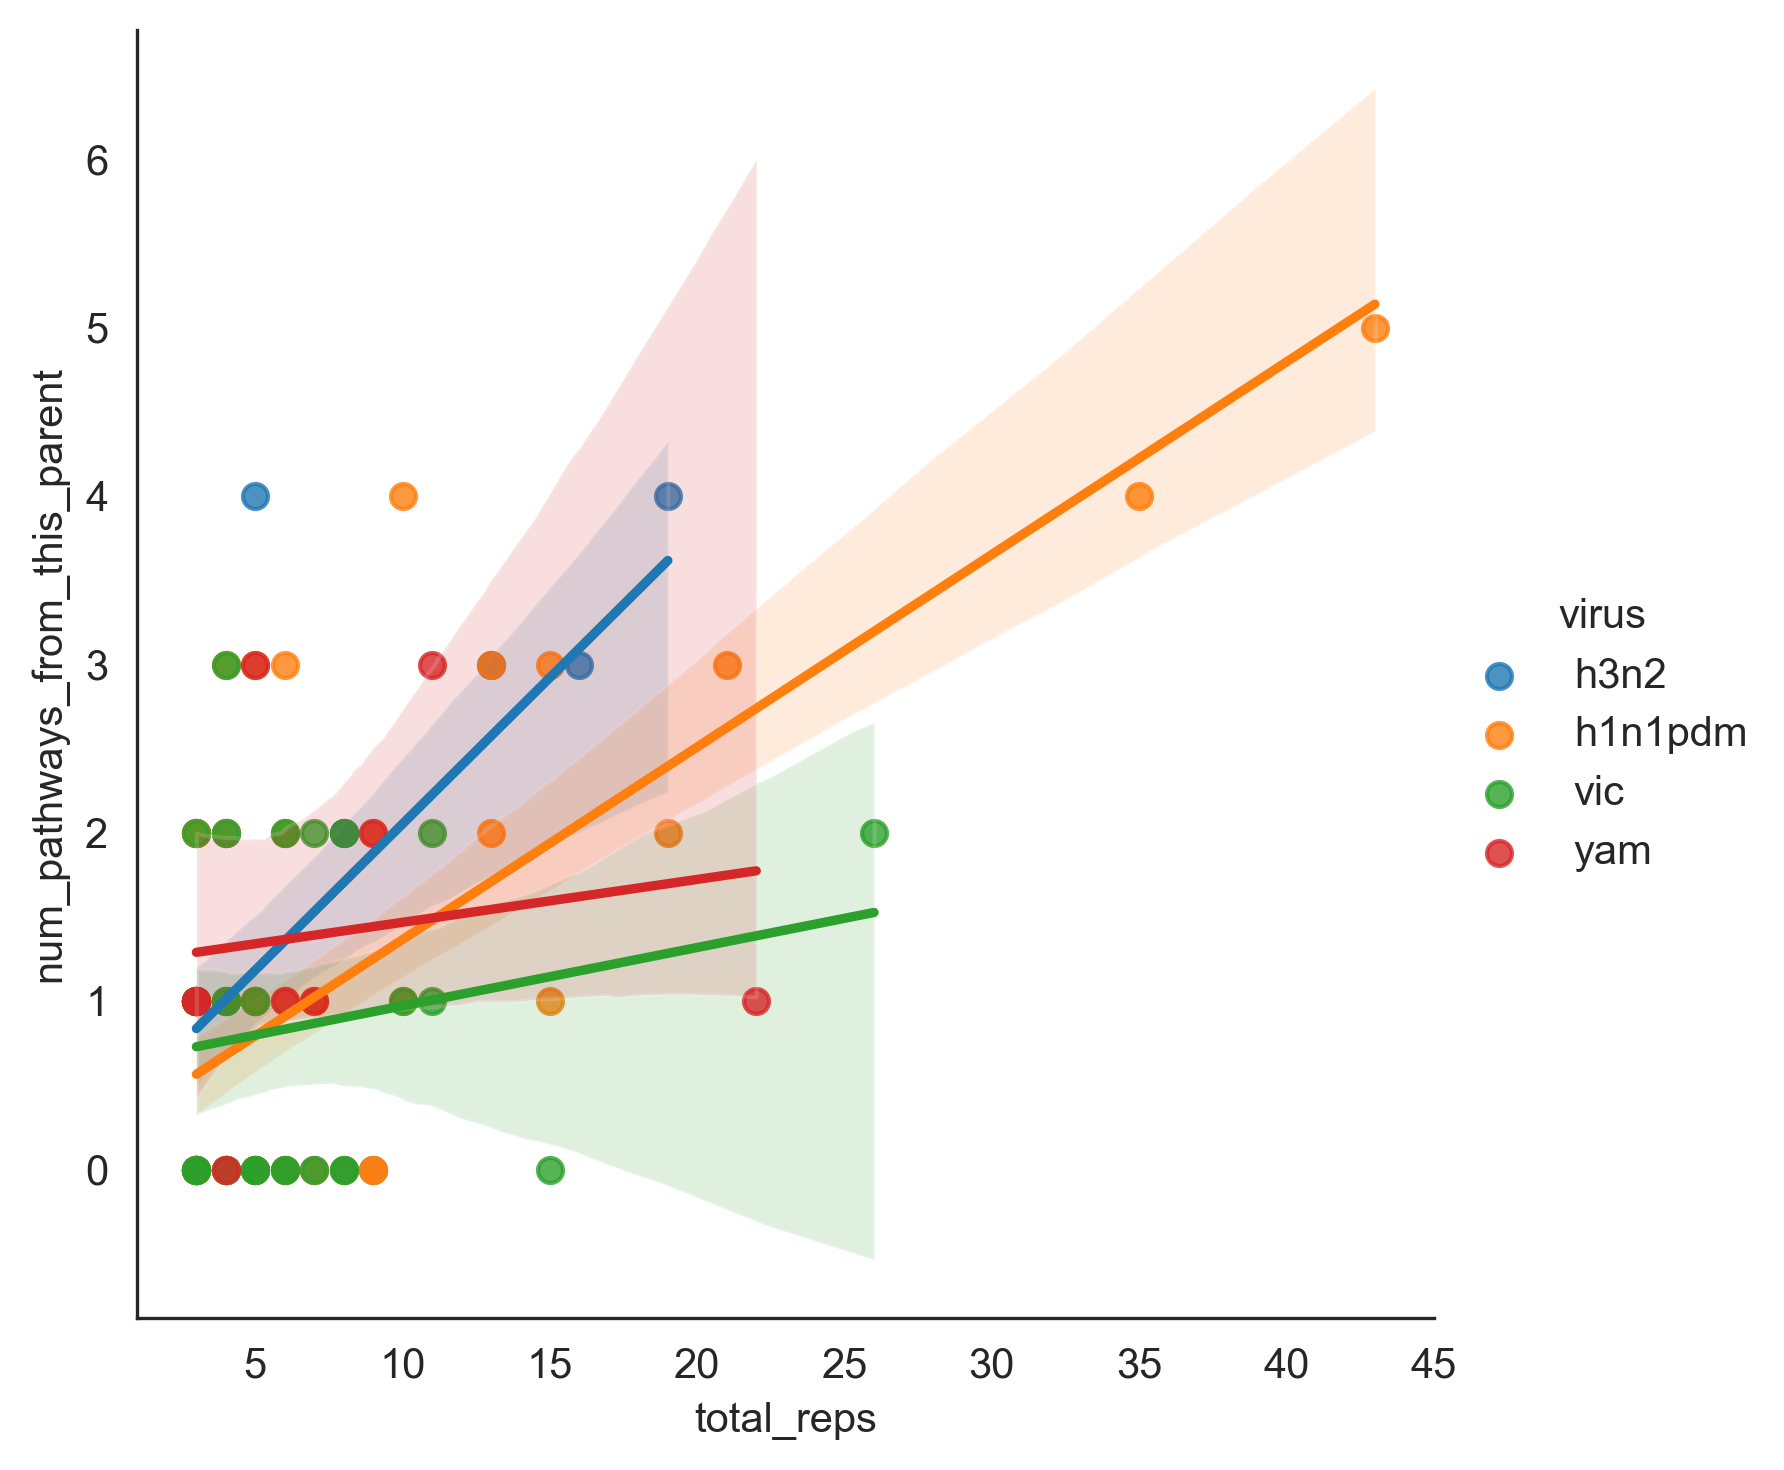

In [102]:
sns.lmplot(data = summary_df, x= 'total_reps', y= 'num_pathways_from_this_parent', hue = 'virus')

sns.despine()

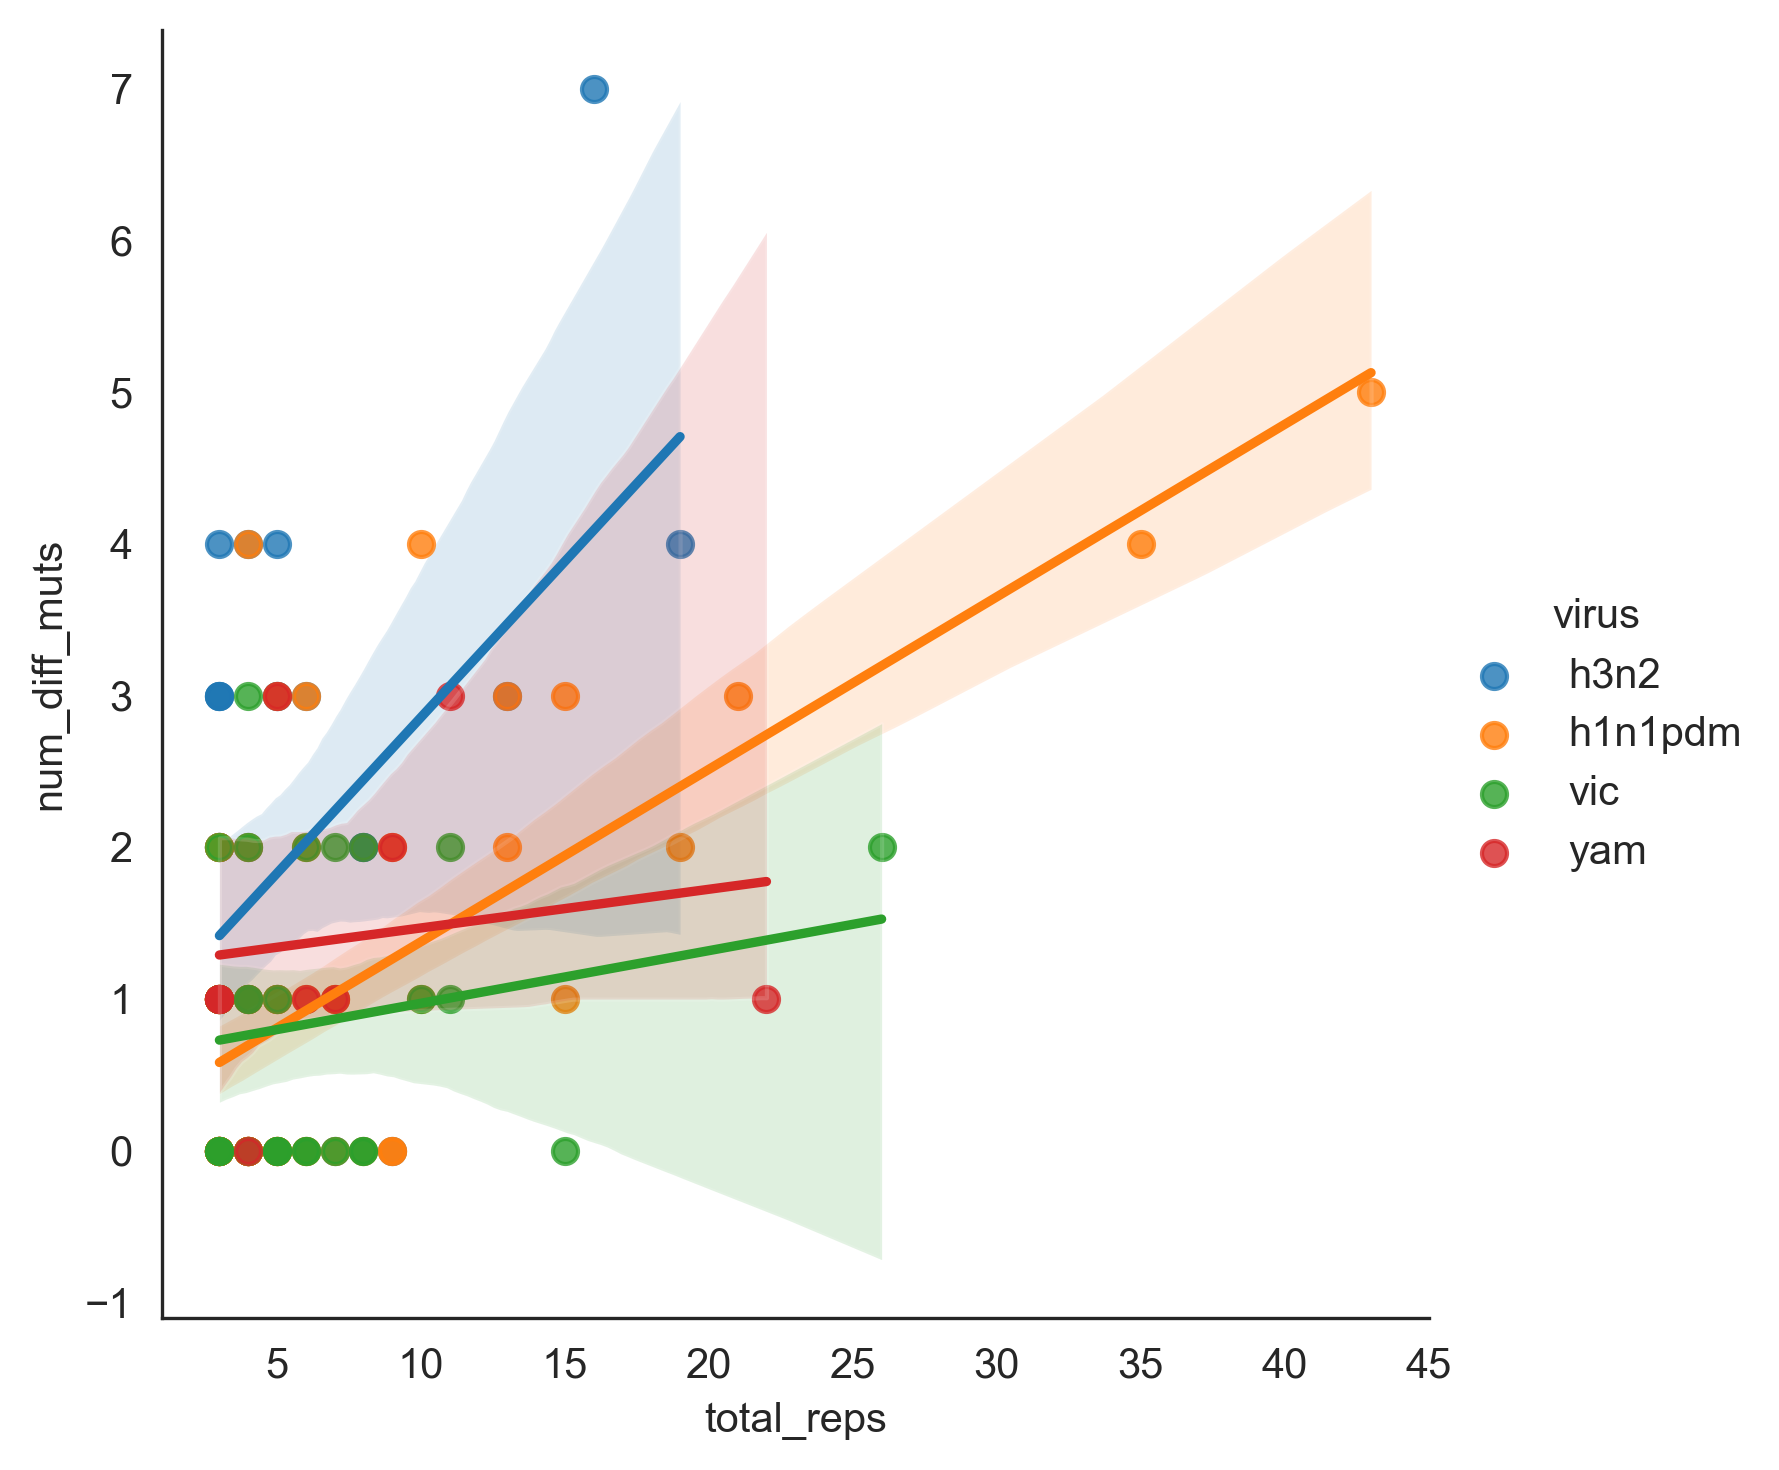

In [101]:
sns.lmplot(data = summary_df, x= 'total_reps', y= 'num_diff_muts', hue = 'virus')

sns.despine()

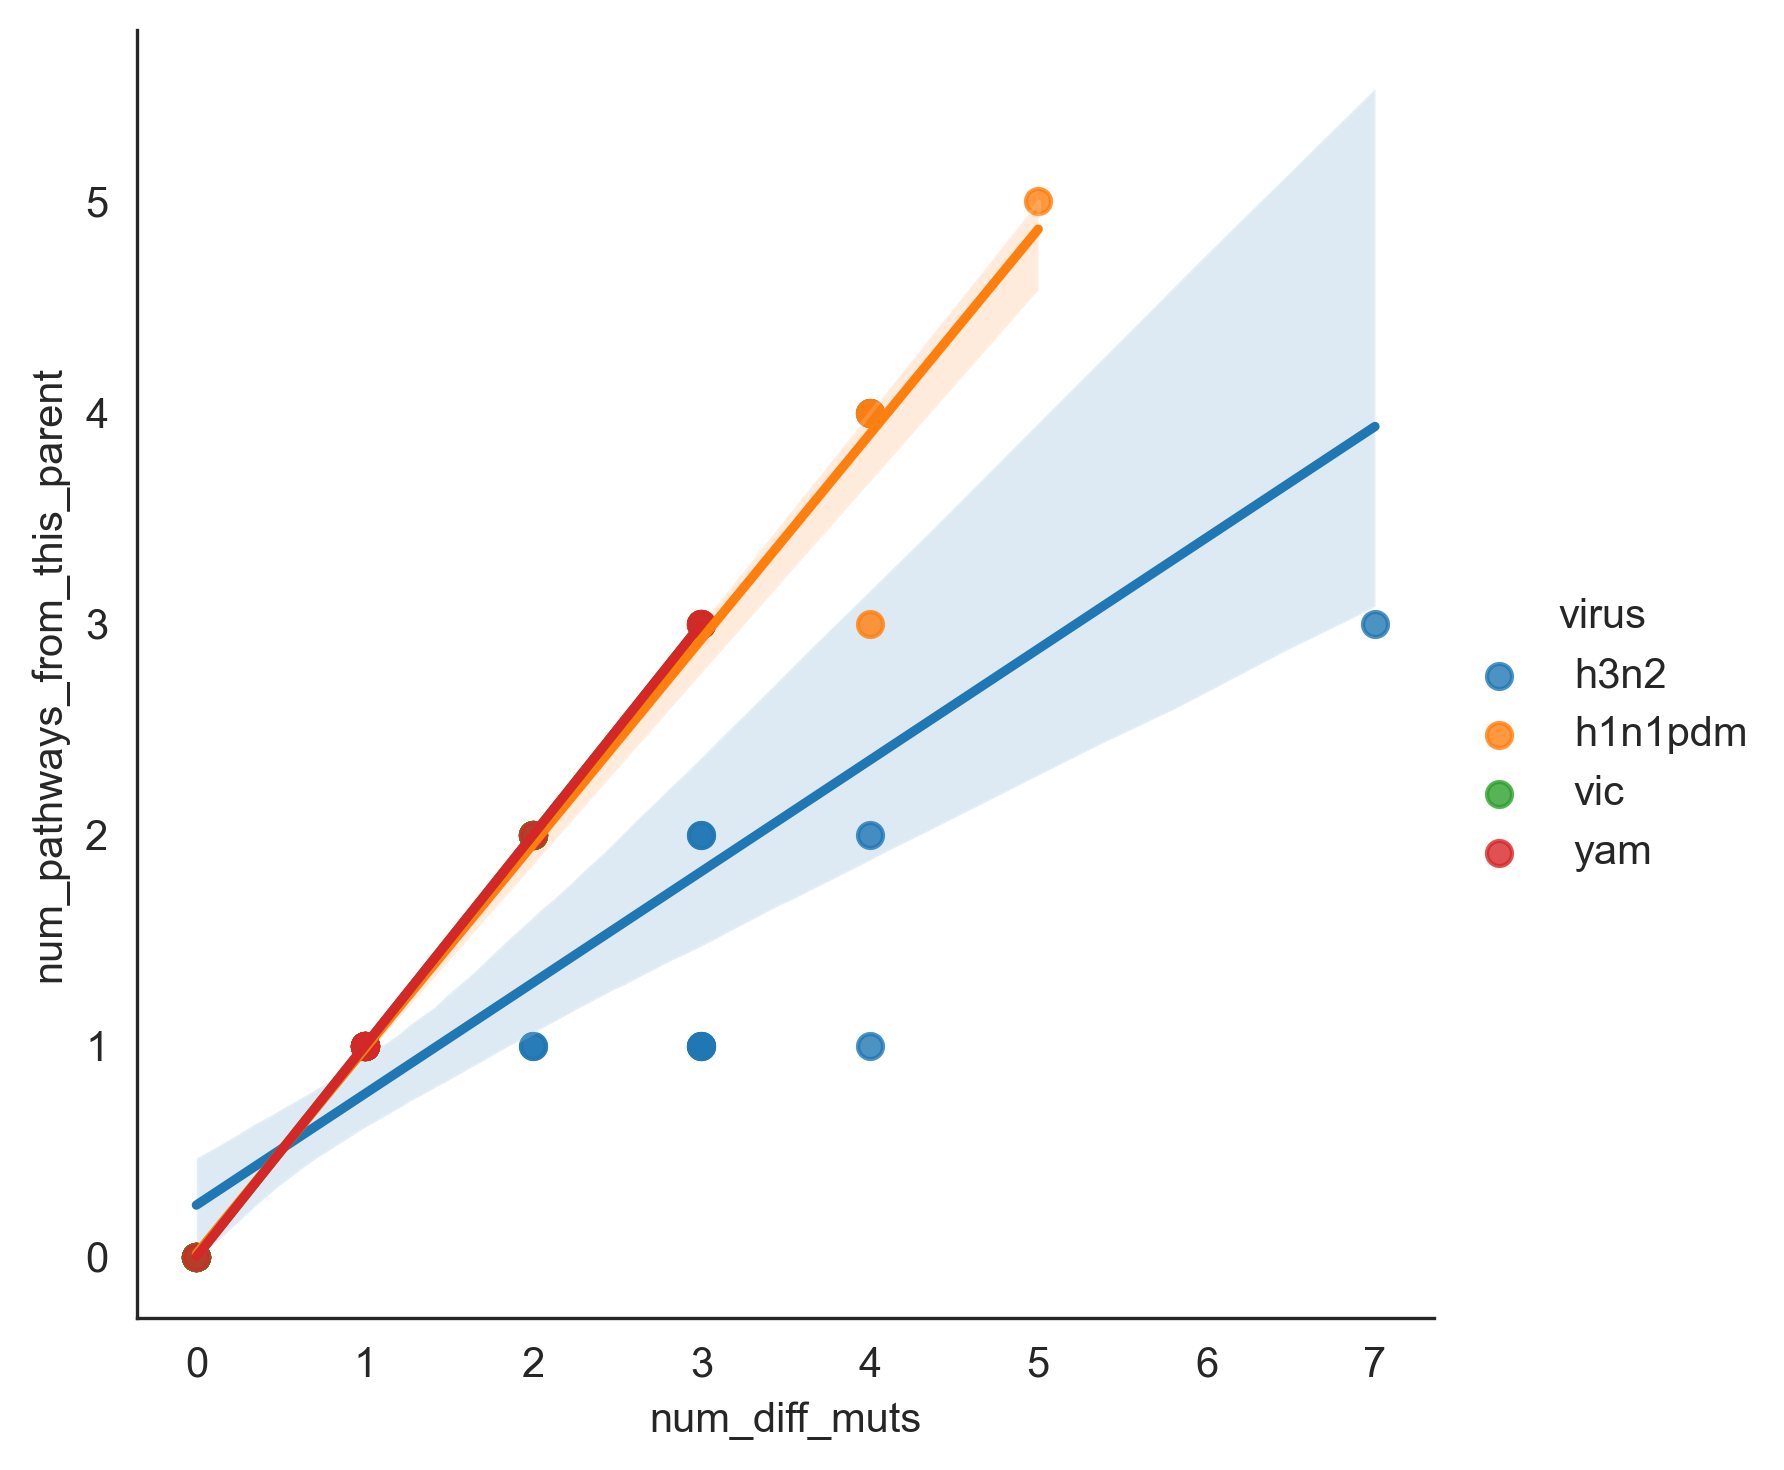

In [99]:
sns.lmplot(data = summary_df, x= 'num_diff_muts', y= 'num_pathways_from_this_parent', hue = 'virus')

sns.despine()